# Исследование по метрикам на основе данных моего произношения

## Импорт библиотеки

In [1]:
# Импорт библиотеки
import sys
import os
import re
import numpy as np
import seaborn as sb
from jiwer import wer, cer, mer, wil

import psycopg2
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Сбор список слов
from collection import collection

## Коллекций слова

In [3]:
for theme, words in collection.items():
    print(f"Тема: {theme}")
    print("Слова:", ', '.join(words))
    print("\n")

Тема: Повседневные разговоры
Слова: привет, здравствуй, дела, новости, планы, увлечения, погода, спорт, еда, фильмы, книги, отпуск, друзья, музыка, работа, хобби, здоровье, компьютер, животные, путешествия, учеба, семья, техника, встреча, отдых, финансы, покупки, событие, время, праздник, до свидания


Тема: Технические
Слова: робот, инженер, автоматизация, электроника, кластеризация, механизм, технология, схема, компонент, программное обеспечение, микроконтроллер, конструкция, инновация, кодирование, энергия, проектирование, технический рисунок, сенсор, трансформатор, оптика, датчик, реактор, прототип, печатная плата, алгоритм, двигатель, вычислитель, автоматика, цифровой


Тема: Бытовые
Слова: пылесос, стиральная машина, микроволновка, кофеварка, утюг, тостер, холодильник, телевизор, пылесборник, посудомоечная машина, блендер, электрочайник, вентилятор, увлажнитель, кондиционер, лампочка, весы, фен, мультиварка, электронагреватель, фильтр, чайник, усилитель сигнала, ручной миксер, ви

## Подключение к БД

In [4]:
# Соединение с БД
conn = psycopg2.connect(
    host="localhost",
    port="5432",
    database="dataset_speech_recognition",
    user="postgres",
    password="postgres"
)
cur = conn.cursor()

In [5]:
# Получение данных из таблицы
cur.execute("SELECT * FROM recognition_data")
data = cur.fetchall()

In [6]:
# Закрытие соединения
cur.close()
conn.close()

## Создание и анализ датафрейма

In [7]:
# Создание DataFrame из полученных данных
df = pd.DataFrame(data, columns=['id', 'data_recognition', 'transcription_word', 'word_for_check', 'date_recoding', 'wer', 'cer', 'mer', 'wil', 'iwer'])

In [8]:
# Преобразование столбца date_recoding в формат datetime
df['date_recoding'] = pd.to_datetime(df['date_recoding'])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3022 entries, 0 to 3021
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  3022 non-null   int64         
 1   data_recognition    3022 non-null   object        
 2   transcription_word  3022 non-null   object        
 3   word_for_check      3022 non-null   object        
 4   date_recoding       3022 non-null   datetime64[ns]
 5   wer                 3022 non-null   float64       
 6   cer                 3022 non-null   float64       
 7   mer                 3022 non-null   float64       
 8   wil                 3022 non-null   float64       
 9   iwer                3022 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(3)
memory usage: 236.2+ KB


In [10]:
df.head()

id                                   data_recognition transcription_word  \
0   1  [b'A', b'A', b'A', b'A', b'A', b'A', b'A', b'A...             рапуд!   
1   2  [b'A', b'A', b'A', b'A', b'A', b'A', b'A', b'A...              крыс!   
2   3  [b'A', b'A', b'A', b'A', b'A', b'A', b'A', b'A...     а в этом суть?   
3   4  [b'A', b'A', b'A', b'A', b'A', b'A', b'A', b'A...       актеристика.   
4   5  [b'A', b'A', b'A', b'A', b'A', b'A', b'A', b'A...          руповерт!   

  word_for_check date_recoding  wer       cer  mer  wil  iwer  
0          робот    2024-04-21  1.0  1.000000  1.0  1.0   0.0  
1        инженер    2024-04-21  1.0  1.000000  1.0  1.0   0.0  
2  автоматизация    2024-04-21  4.0  0.846154  1.0  1.0   0.0  
3    электроника    2024-04-21  1.0  0.727273  1.0  1.0   0.0  
4          робот    2024-04-22  1.0  1.200000  1.0  1.0   0.0

In [11]:
# Экспорт DataFrame в CSV файл
df.to_csv('database.csv', index=False)

##### Поскольку модель выдавала текст с знаками и другие, поэтому будем устранять их и заново рассчитать метрику

## Предобработка данных

### Изменение индеса в временный ряд

In [12]:
# Отбросим ненужные столбцы
research_df = df.drop(['id', 'data_recognition'], axis=1)

# Установим индекс по столбцу 'date_recoding'
research_df = research_df.set_index('date_recoding')

# Убедимся, что индекс отсортирован
research_df = research_df.sort_index()

In [13]:
research_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3022 entries, 2024-04-21 to 2024-05-19
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   transcription_word  3022 non-null   object 
 1   word_for_check      3022 non-null   object 
 2   wer                 3022 non-null   float64
 3   cer                 3022 non-null   float64
 4   mer                 3022 non-null   float64
 5   wil                 3022 non-null   float64
 6   iwer                3022 non-null   float64
dtypes: float64(5), object(2)
memory usage: 188.9+ KB


### Установка диапазона времени дат

In [14]:
# Фильтруем данные по диапазону дат
start_date = '2024-04-23'
end_date = '2024-05-17'

research_df = research_df.loc[start_date:end_date]

In [15]:
# Создаем пустой список для хранения названий тем
theme_column = []

# Проверяем каждое слово из столбца word_for_check
for word in research_df['word_for_check']:
    found = False
    # Проверяем каждую тему и их слова
    for theme, words in collection.items():
        # Если слово найдено в текущей теме, добавляем название темы в список и выходим из цикла
        if word in words:
            theme_column.append(theme)
            found = True
            break
    # Если слово не найдено в ни одной теме, добавляем значение None в список
    if not found:
        theme_column.append(None)

# Добавляем новый столбец с названиями тем в research_df
research_df['theme'] = theme_column

In [16]:
# Удаление значений None из столбца theme
research_df.dropna(subset=['theme'], inplace=True)

# Проверим, есть ли пустые темы?
research_df[research_df['theme'] == None].count()

transcription_word    0
word_for_check        0
wer                   0
cer                   0
mer                   0
wil                   0
iwer                  0
theme                 0
dtype: int64

In [17]:
research_df['theme'].unique()

array(['Научные', 'Космос', 'Медицина', 'Повседневные разговоры',
       'Бытовые', 'Технические'], dtype=object)

### Удаление лишних знаков в тексте

In [18]:
def clean_text(text):
    # Удаление всех знаков пунктуации
    return re.sub(r'[^\w\s]', '', text)

In [19]:
research_df['transcription_word'] = research_df['transcription_word'].apply(clean_text)

In [20]:
research_df.head()

transcription_word word_for_check  wer       cer  mer  wil  \
date_recoding                                                              
2024-04-23             в контору       контроль  2.0  0.750000  1.0  1.0   
2024-04-23                     и         звезда  1.0  1.000000  1.0  1.0   
2024-04-23               рептили        реакция  1.0  0.714286  1.0  1.0   
2024-04-23          батлеровники  моделирование  1.0  0.692308  1.0  1.0   
2024-04-23              ой блядь           опыт  2.0  2.000000  1.0  1.0   

               iwer    theme  
date_recoding                 
2024-04-23      0.0  Научные  
2024-04-23      0.0   Космос  
2024-04-23      0.0  Научные  
2024-04-23      0.0  Научные  
2024-04-23      0.0  Научные

### Установка метрик

In [21]:
def iwer(reference_sentence, hypothesis_sentence) -> float:
    """
    Вычисляет Inflectional Word Error Rate (IWER) между предложением-эталоном и гипотезой.

    Параметры:
    reference_sentence (str): Предложение-эталон (правильный вариант).
    hypothesis_sentence (str): Гипотеза (предсказанный вариант).

    Возвращает:
    float: Значение Inflectional Word Error Rate (IWER) в процентах.
    """
    reference_words = reference_sentence.split()
    hypothesis_words = hypothesis_sentence.split()

    # Находим количество слов в предложении-эталоне
    total_words = len(reference_words)

    # Считаем количество неправильно распознанных слов
    incorrect_words = sum(1 for ref, hyp in zip(reference_words, hypothesis_words) if ref != hyp)

    # Вычисляем Inflectional Word Error Rate (IWER)
    iwer_score = incorrect_words / total_words

    return iwer_score

In [22]:
def calculate_metrics(df):
    df['wer'] = df.apply(lambda row: wer(row['word_for_check'], row['transcription_word']), axis=1)
    df['cer'] = df.apply(lambda row: cer(row['word_for_check'], row['transcription_word']), axis=1)
    df['mer'] = df.apply(lambda row: mer(row['word_for_check'], row['transcription_word']), axis=1)
    df['wil'] = df.apply(lambda row: wil(row['word_for_check'], row['transcription_word']), axis=1)
    df['iwer'] = df.apply(lambda row: iwer(row['word_for_check'], row['transcription_word']), axis=1)

    return df

In [23]:
# Вычисление метрик
research_df = calculate_metrics(research_df)

In [24]:
research_df.head(10)

transcription_word word_for_check  wer       cer  mer  wil  \
date_recoding                                                              
2024-04-23             в контору       контроль  2.0  0.625000  1.0  1.0   
2024-04-23                     и         звезда  1.0  1.000000  1.0  1.0   
2024-04-23               рептили        реакция  1.0  0.714286  1.0  1.0   
2024-04-23          батлеровники  моделирование  1.0  0.615385  1.0  1.0   
2024-04-23              ой блядь           опыт  2.0  1.750000  1.0  1.0   
2024-04-23                я жива        теорема  2.0  0.857143  1.0  1.0   
2024-04-23                  спит         спектр  1.0  0.500000  1.0  1.0   
2024-04-23     афина сделай стоп        планета  3.0  2.000000  1.0  1.0   
2024-04-23                   куг      галактика  1.0  0.888889  1.0  1.0   
2024-04-23                выбран           луна  1.0  1.250000  1.0  1.0   

               iwer    theme  
date_recoding                 
2024-04-23      1.0  Научные  
2024-04-23      1.0   Космос  
2024-04-23      1.0  Научные  
2024-04-23      1.0  Научные  
2024-04-23      1.0  Научные  
2024-04-23      1.0  Научные  
2024-04-23      1.0  Научные  
2024-04-23      1.0   Космос  
2024-04-23      1.0   Космос  
2024-04-23      1.0   Космос

In [25]:
research_df[research_df['word_for_check'] == 'робот'].head

<bound method NDFrame.head of               transcription_word word_for_check  wer  cer  mer  wil  iwer  \
date_recoding                                                               
2024-04-23                   ром          робот  1.0  0.6  1.0  1.0   1.0   
2024-04-24                рупоть          робот  1.0  0.6  1.0  1.0   1.0   
2024-04-25                 салют          робот  1.0  0.8  1.0  1.0   1.0   
2024-04-29       ангина джангира          робот  2.0  3.0  1.0  1.0   1.0   
2024-04-30               пробуть          робот  1.0  0.6  1.0  1.0   1.0   
2024-05-02              хорошего          робот  1.0  1.2  1.0  1.0   1.0   
2024-05-03                 робот          робот  0.0  0.0  0.0  0.0   0.0   
2024-05-05                 робот          робот  0.0  0.0  0.0  0.0   0.0   
2024-05-06                     а          робот  1.0  1.0  1.0  1.0   1.0   
2024-05-08                 робот          робот  0.0  0.0  0.0  0.0   0.0   
2024-05-09                 робот          робо

## Анализ данных

In [26]:
# Сохраняем метрики
metrics = ['wer', 'cer', 'mer', 'wil', 'iwer']

# Словарь цветов для метрик
colors = {
    'wer': 'blue',
    'cer': 'orange',
    'mer': 'green',
    'wil': 'black',
    'iwer': 'purple'
}

### Функция отрисовки графики

In [27]:
def draw_plot(word):
    # Фильтрация данных по слову
    filtered_df = research_df[research_df['word_for_check'] == word].sort_index()

    for metric in metrics:
        # Построение графика
        plt.figure(figsize=(15, 5))
        plt.plot(filtered_df.index, filtered_df[metric], marker='o', linestyle='-', color=colors[metric], label=metric.upper())
        
        # Скользящее среднее
        rolling_mean = filtered_df[metric].rolling(window=3).mean()
        plt.plot(filtered_df.index, rolling_mean, color='red', linestyle='--', label=f'{metric.upper()} (3-дневное скользящее среднее)')
        
        plt.title(f'Динамика {metric.upper()} для слова "{word}"', fontweight='bold', fontsize=12)
        plt.xlabel('Дата', fontweight='bold', fontsize=12)
        plt.ylabel(metric.upper(), fontweight='bold', fontsize=12)
        plt.grid(True)
        plt.xticks(rotation=45)
        
        # Добавление надписей
        for idx, row in filtered_df.iterrows():
            plt.annotate(row['transcription_word'], (idx, row[metric]), textcoords="offset points", xytext=(0,10), ha='center', rotation=45)
        
        plt.legend()
        plt.tight_layout()
        
        # Показ графика
        plt.show()

### Динамика метрики в течение времени

Случайным образом буду выбирать слова и исследовать динамику метрики в течение времени

#### Повседневные разговоры - слово "Фильмы"

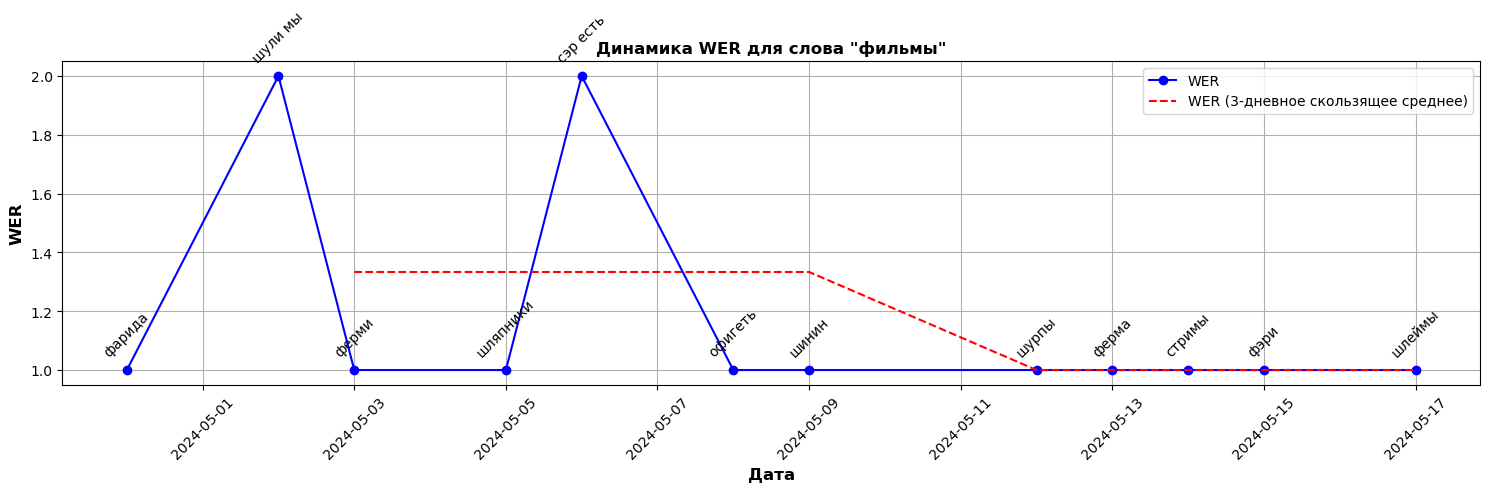

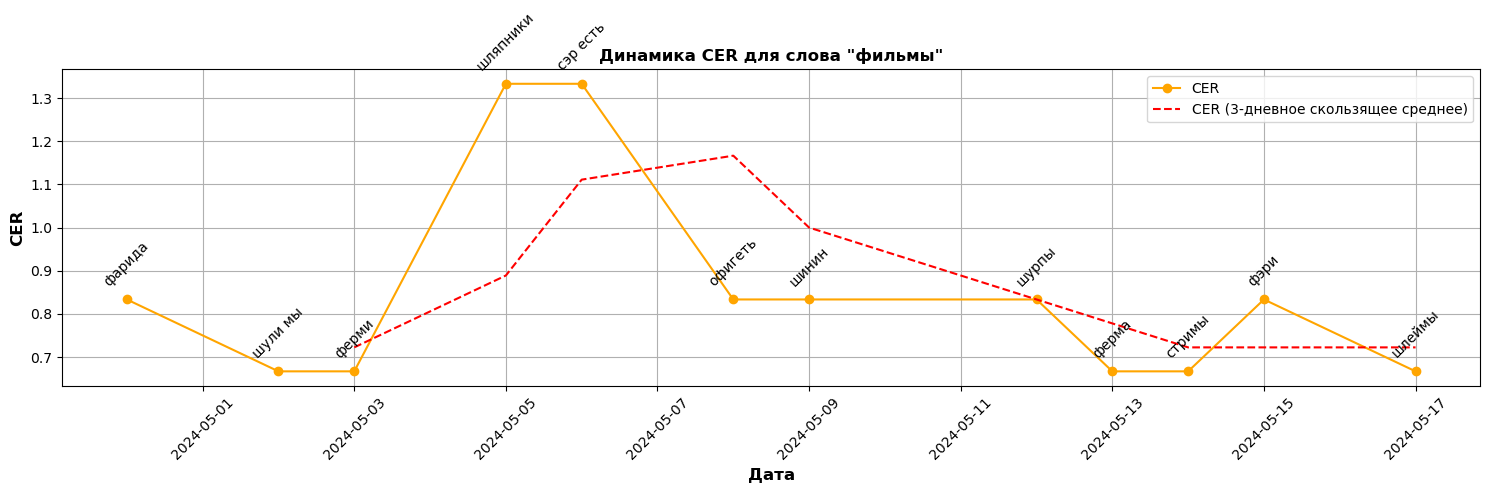

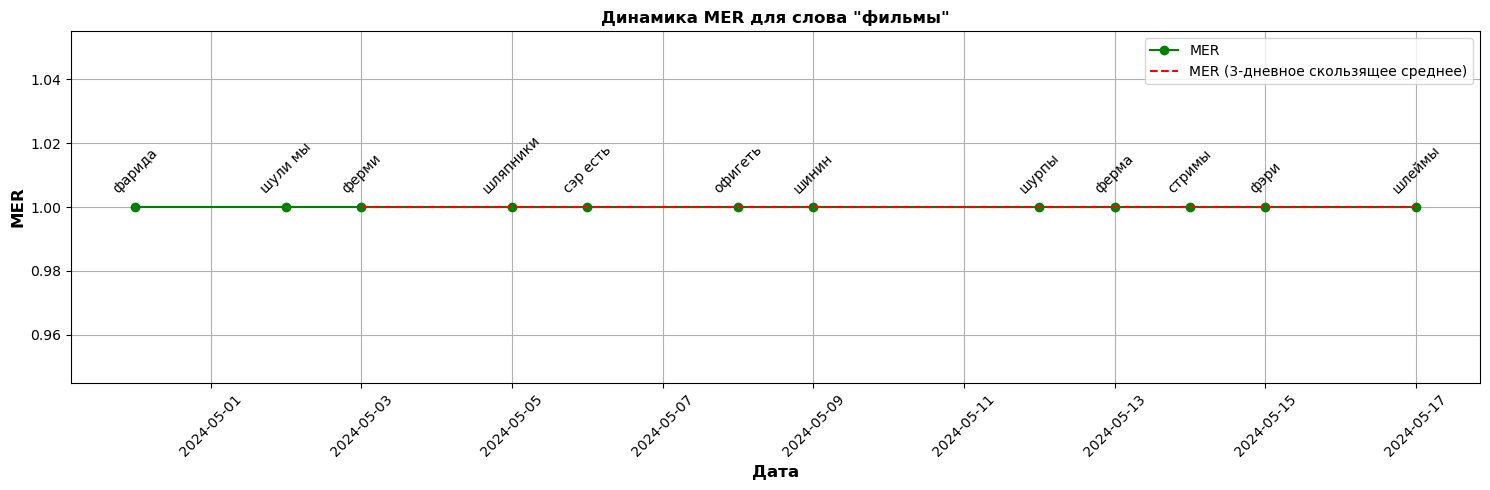

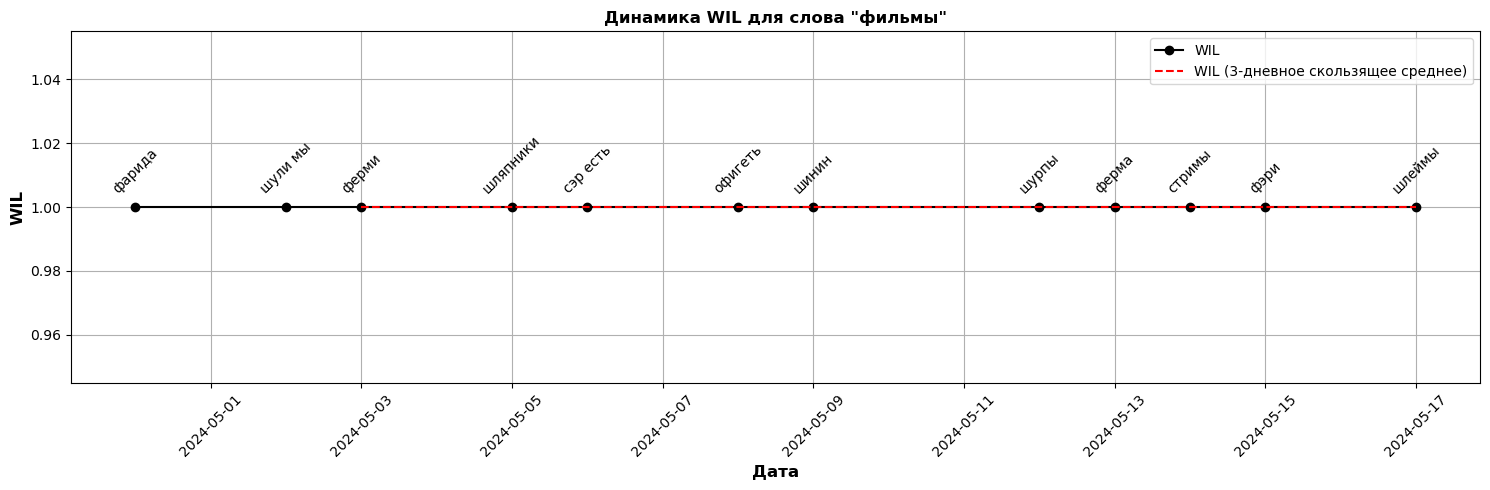

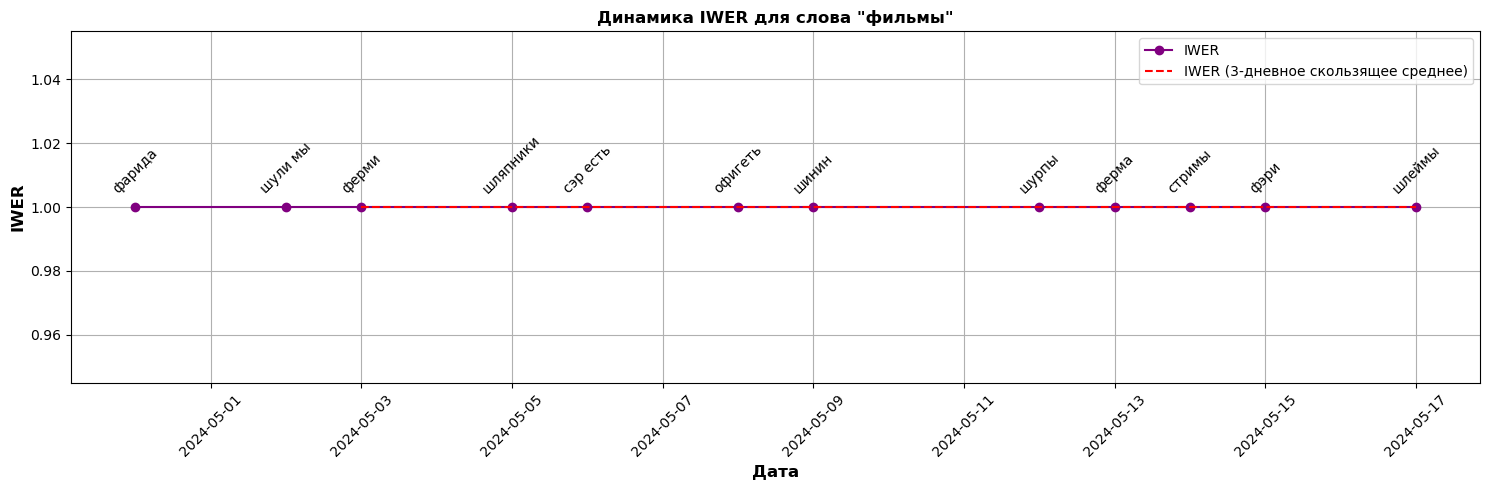

In [28]:
draw_plot('фильмы')

#### Технические - слово "Робот"

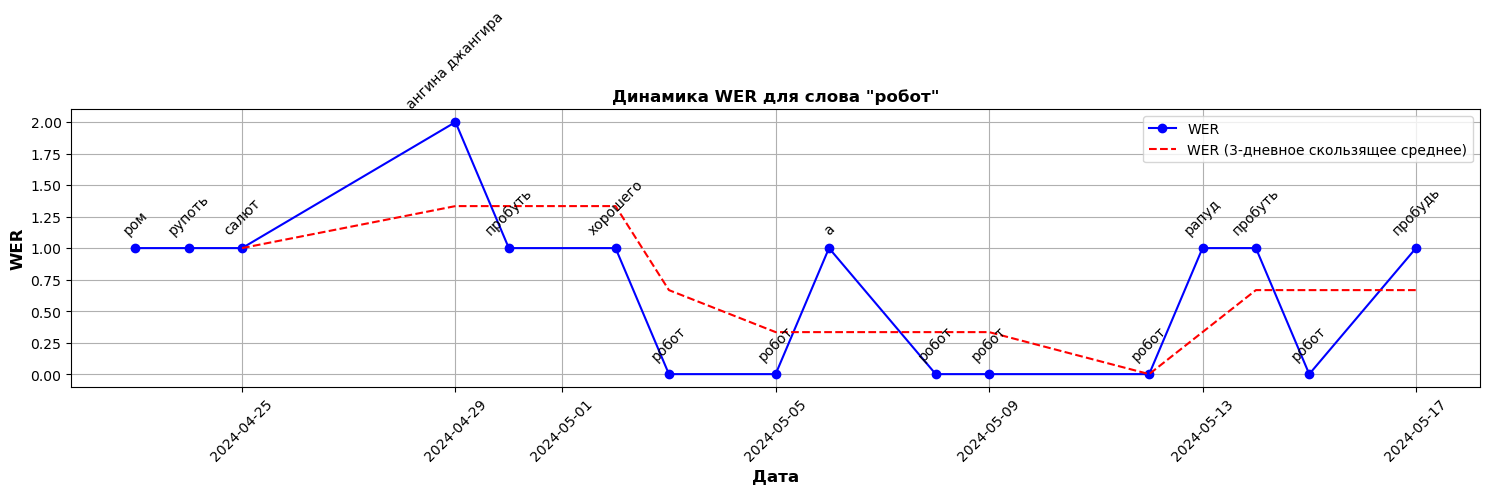

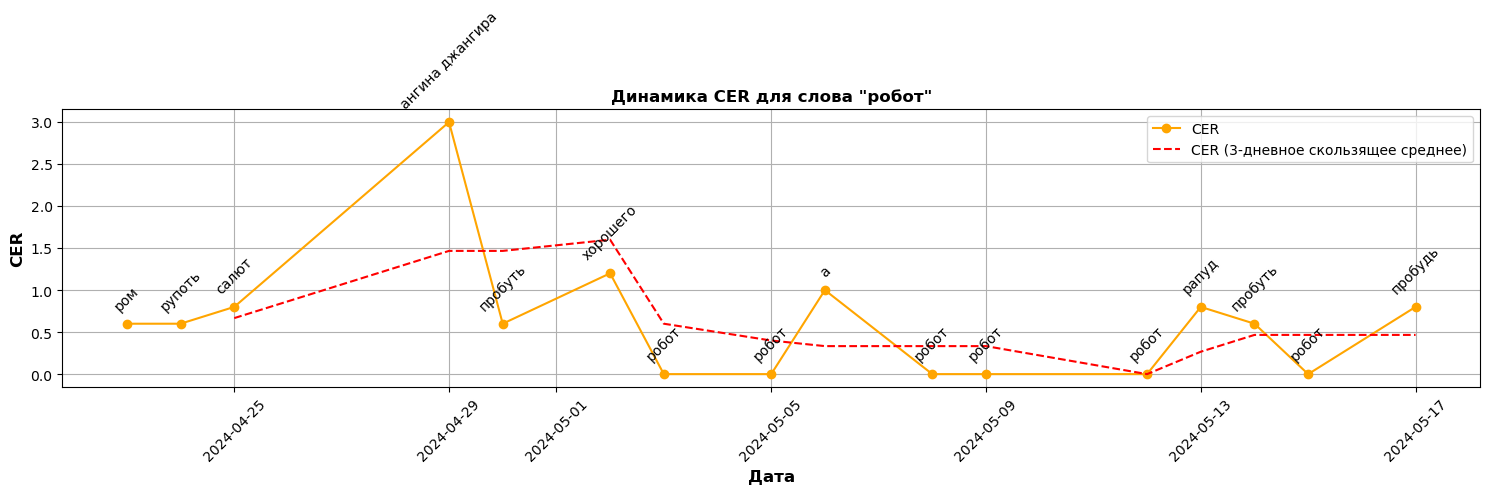

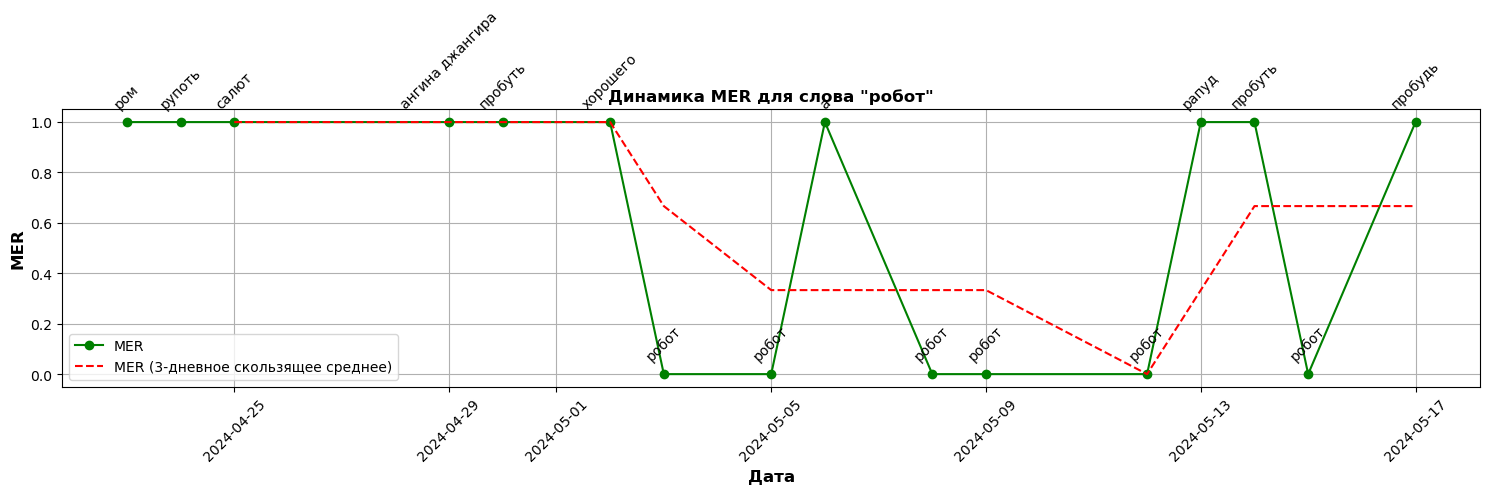

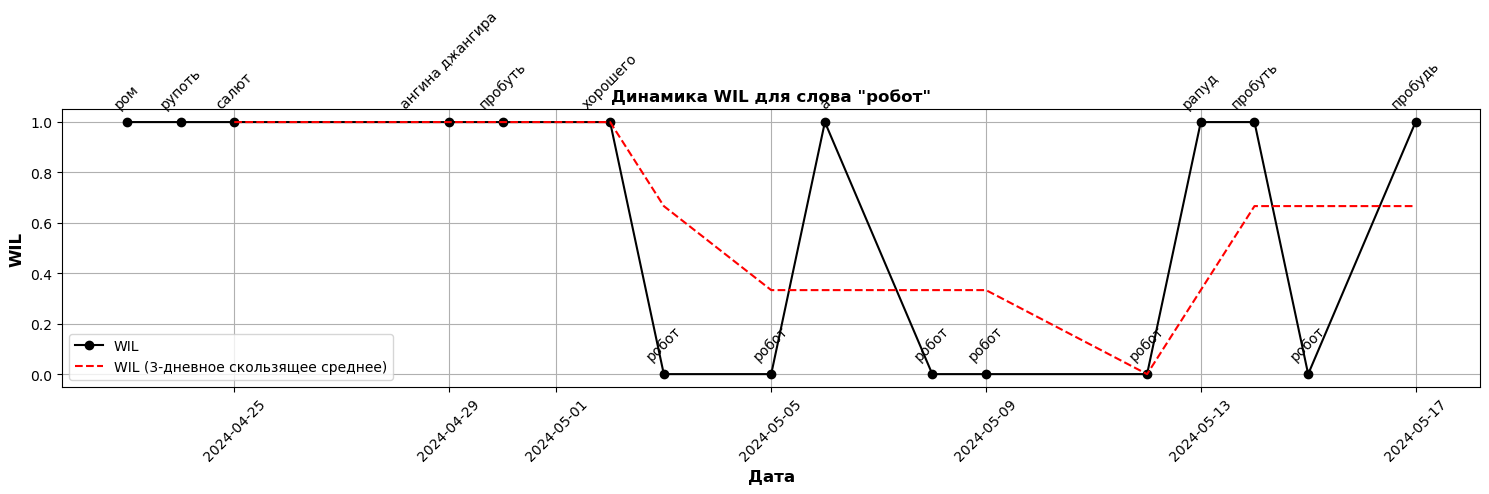

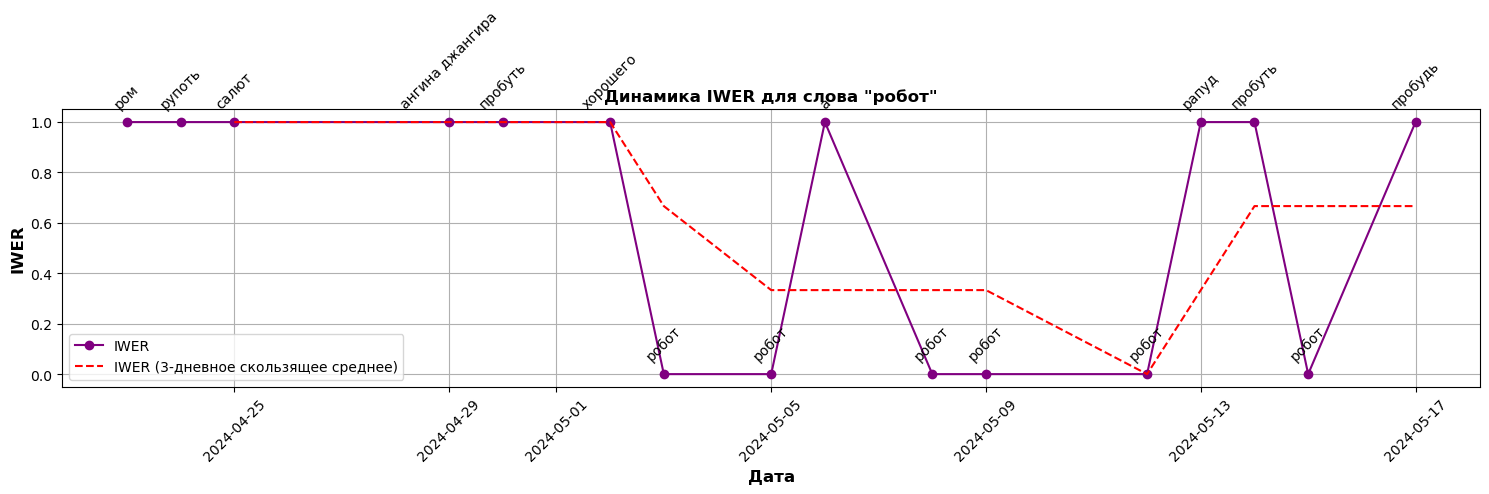

In [29]:
draw_plot('робот')

#### Бытовые - слово "Микроволновка"

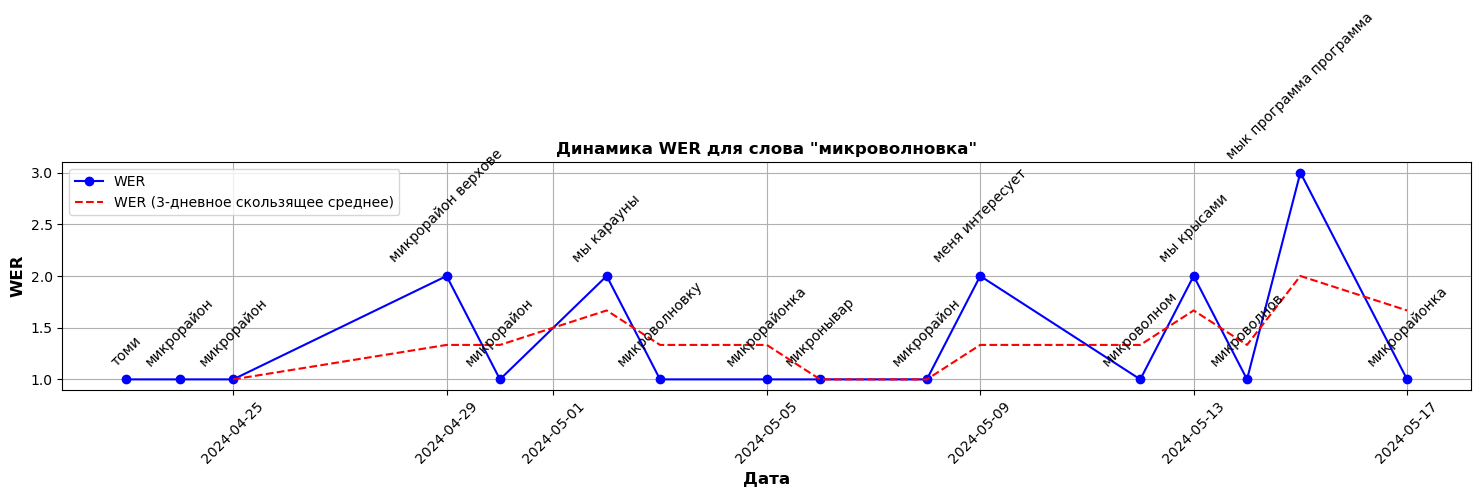

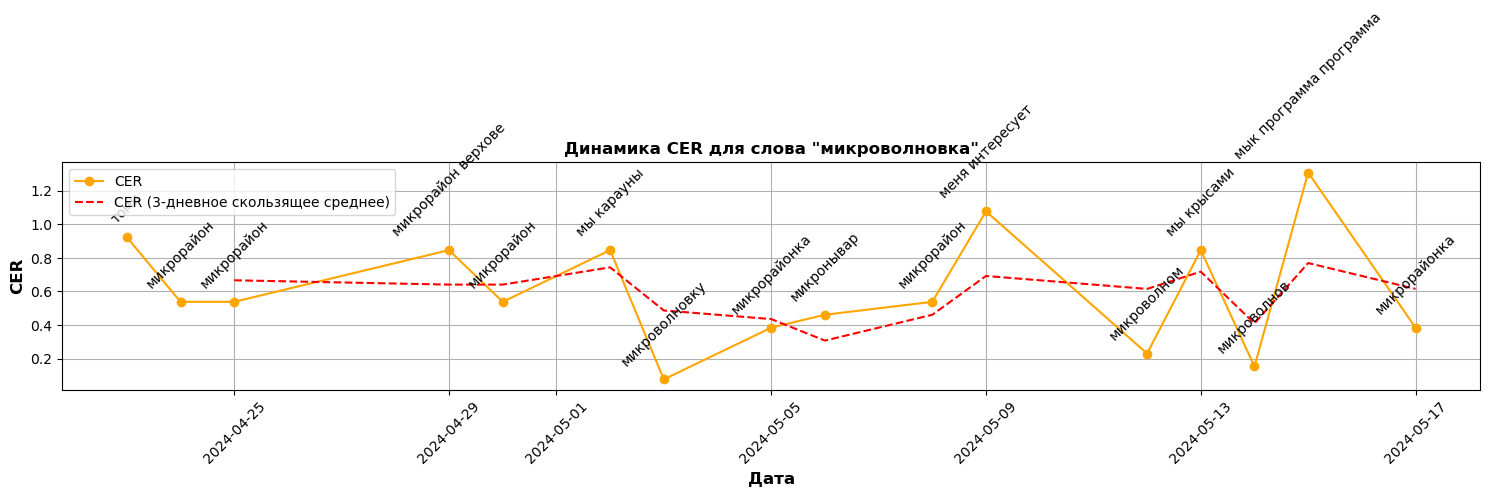

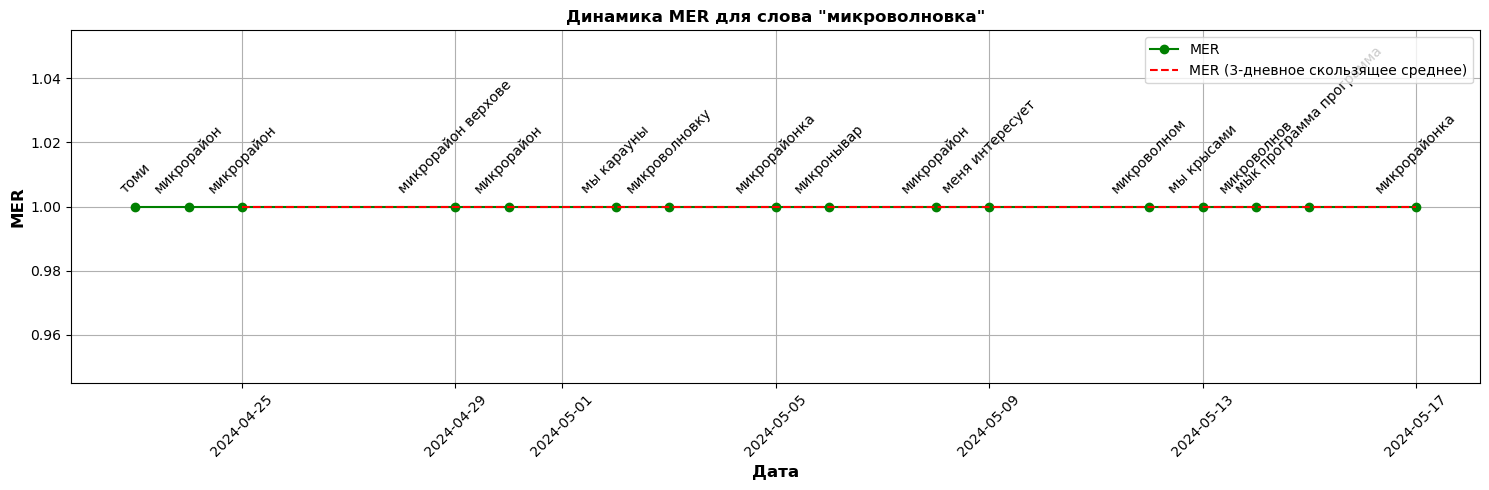

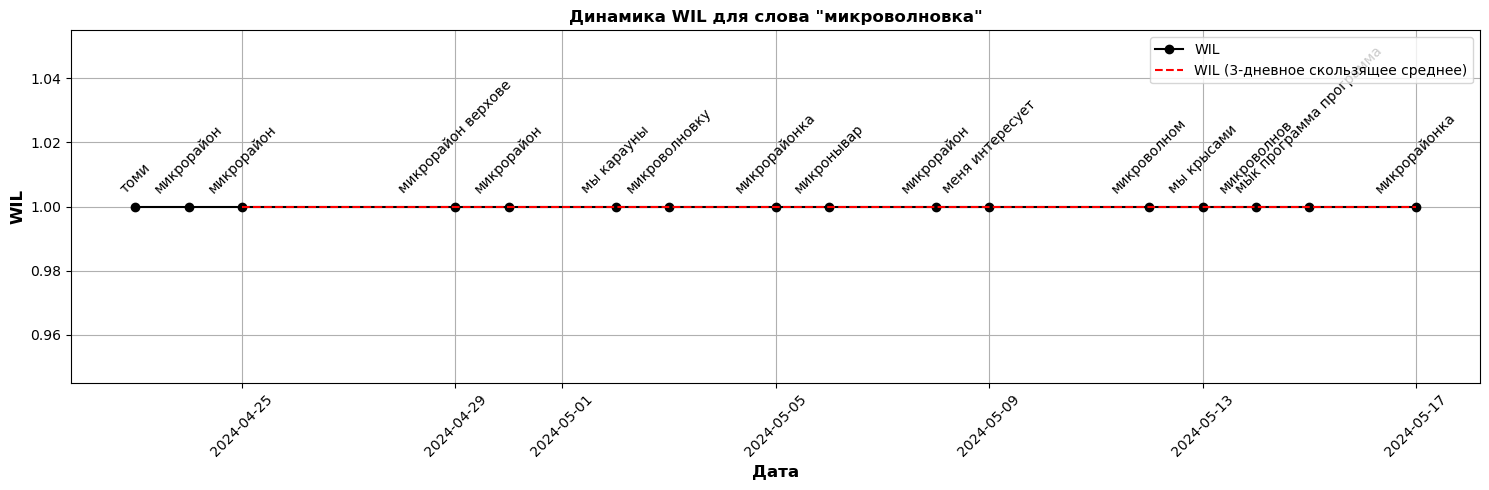

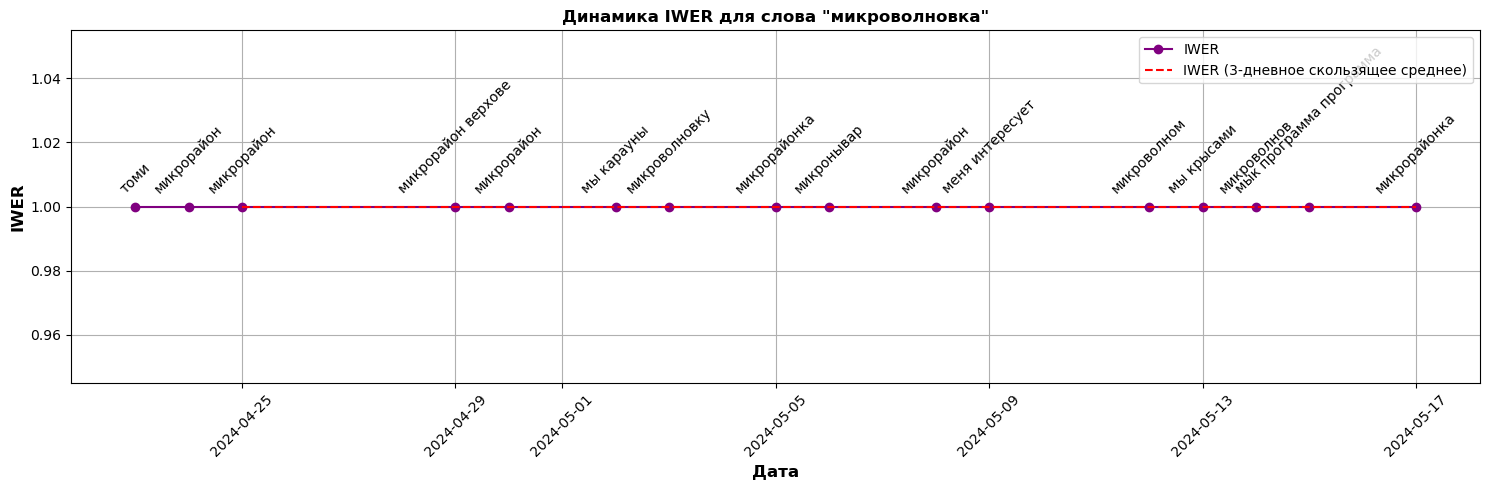

In [30]:
draw_plot('микроволновка')

#### Научные - слово "Инженерия"

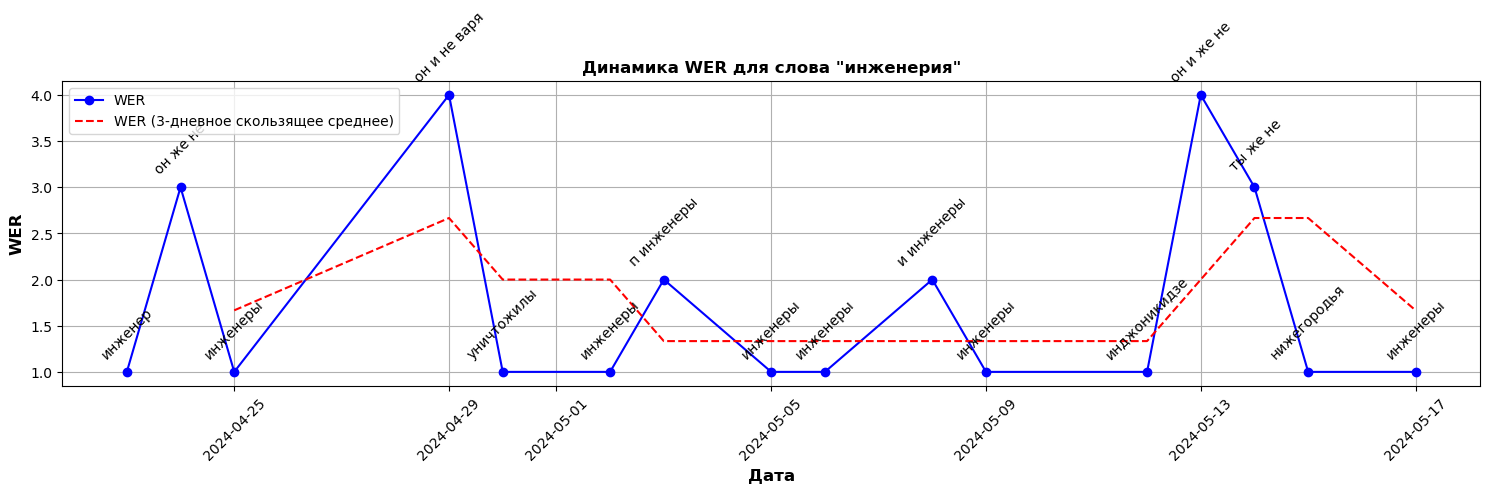

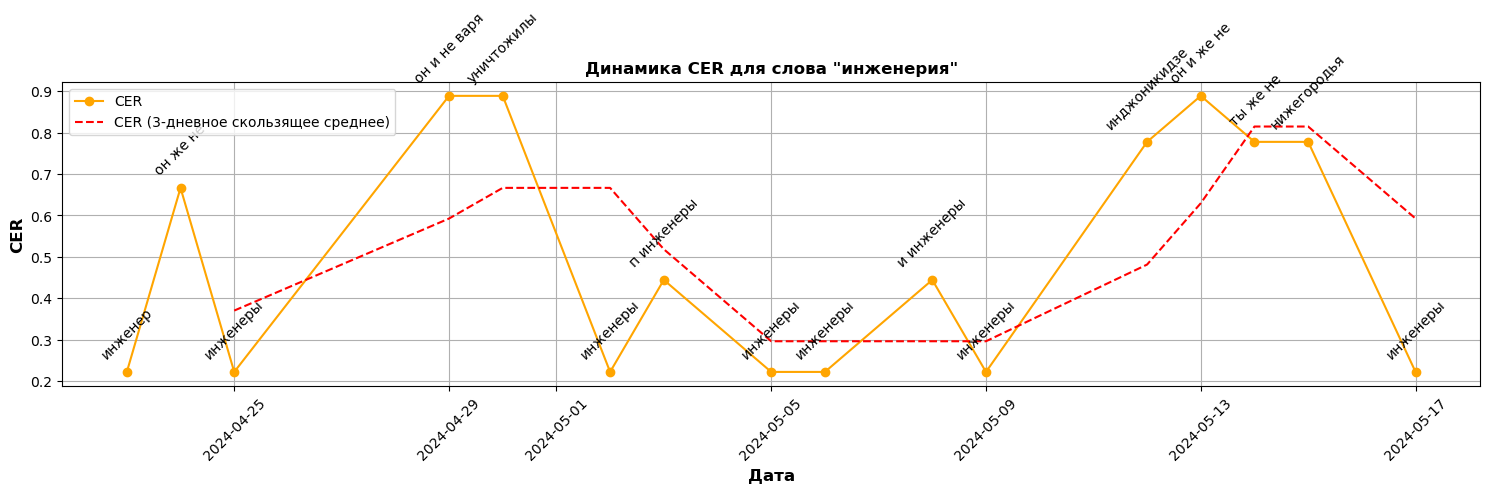

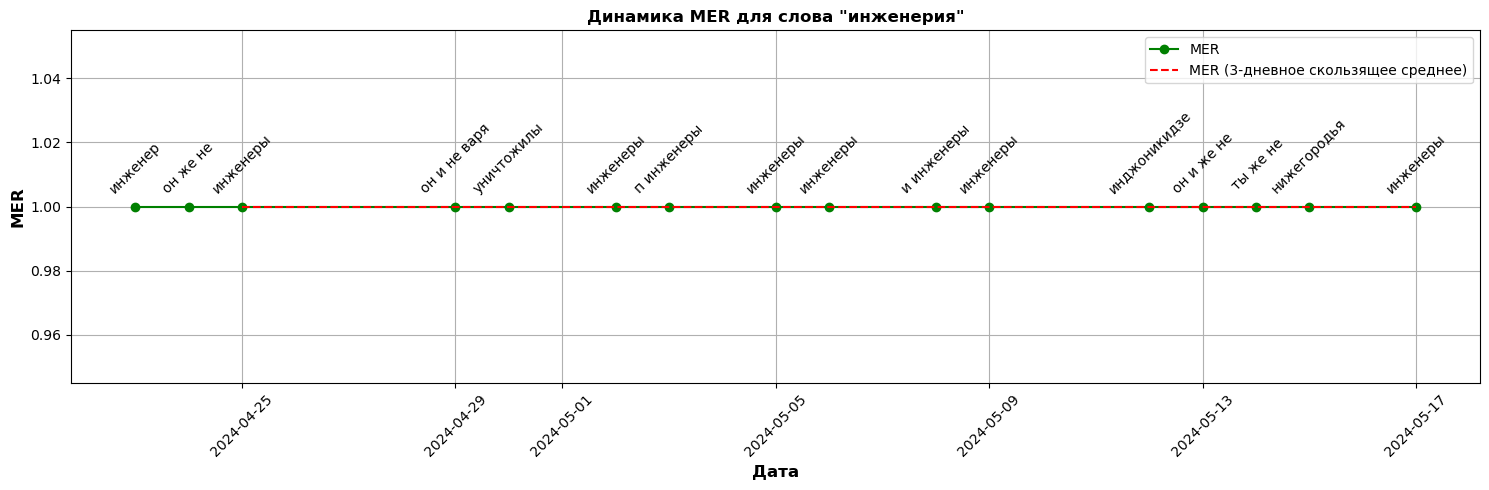

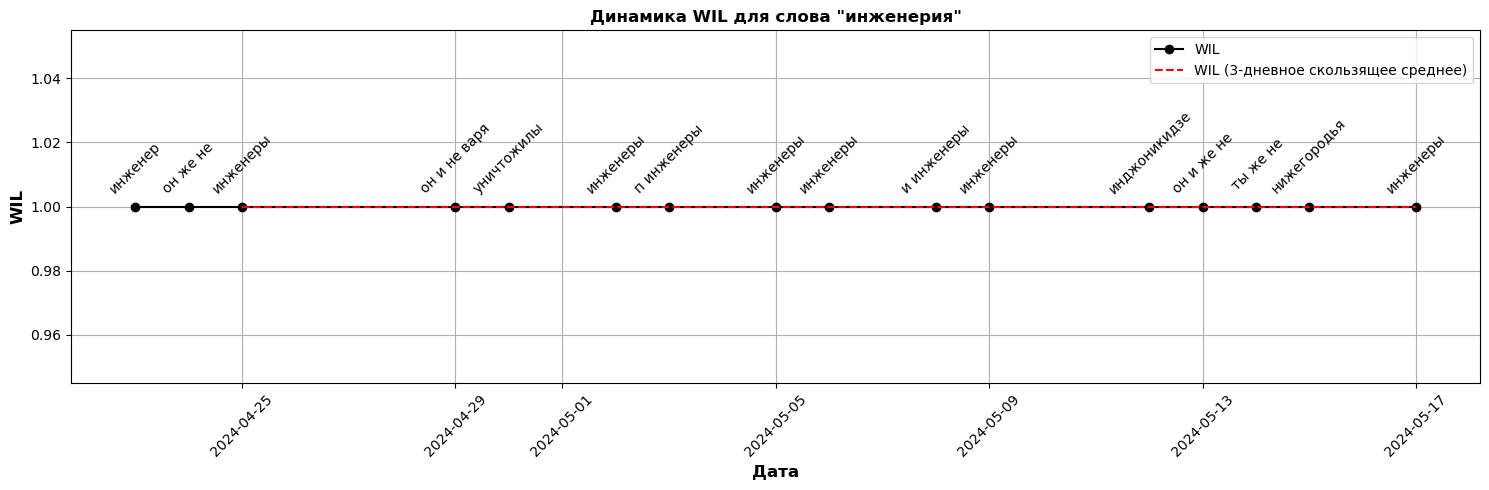

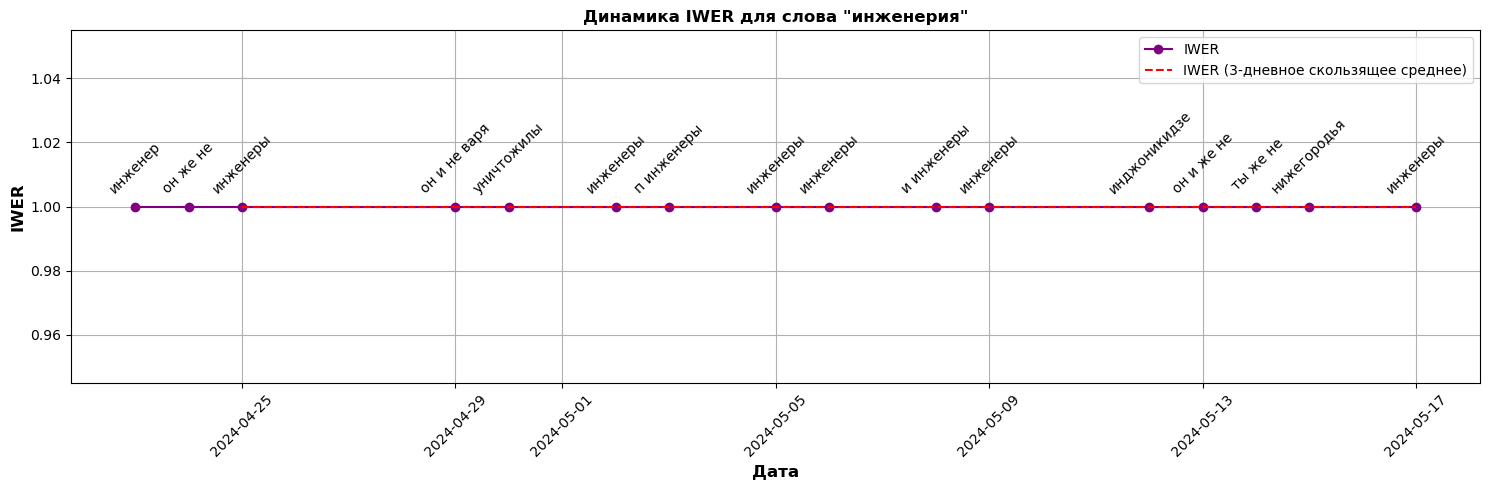

In [31]:
draw_plot('инженерия')

#### Космос - слово "Астрофизика"

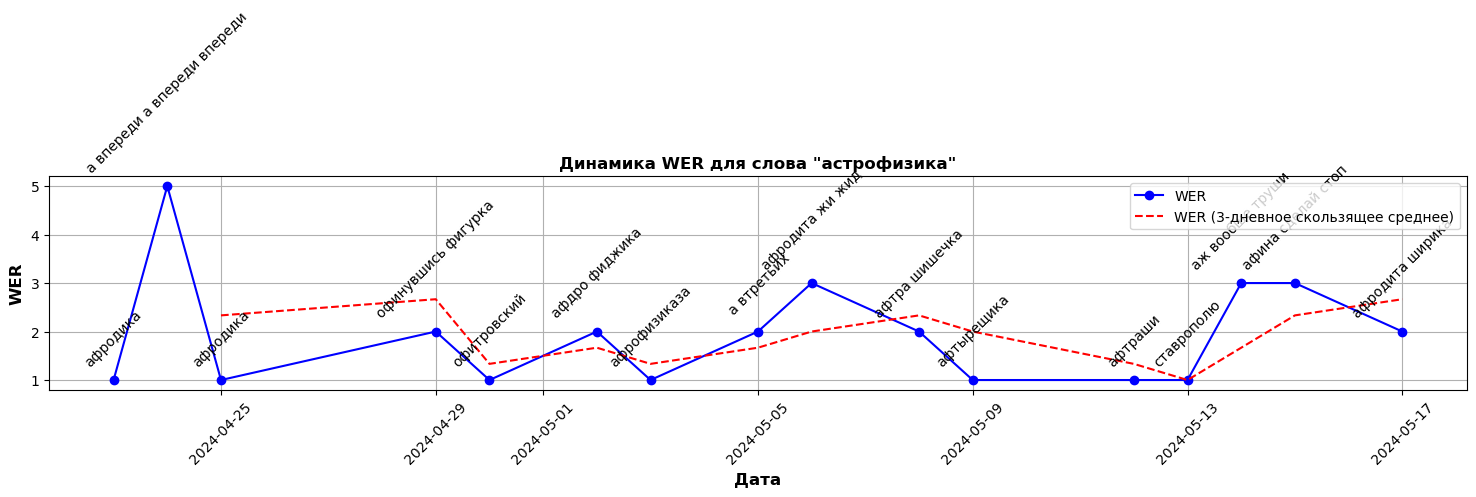

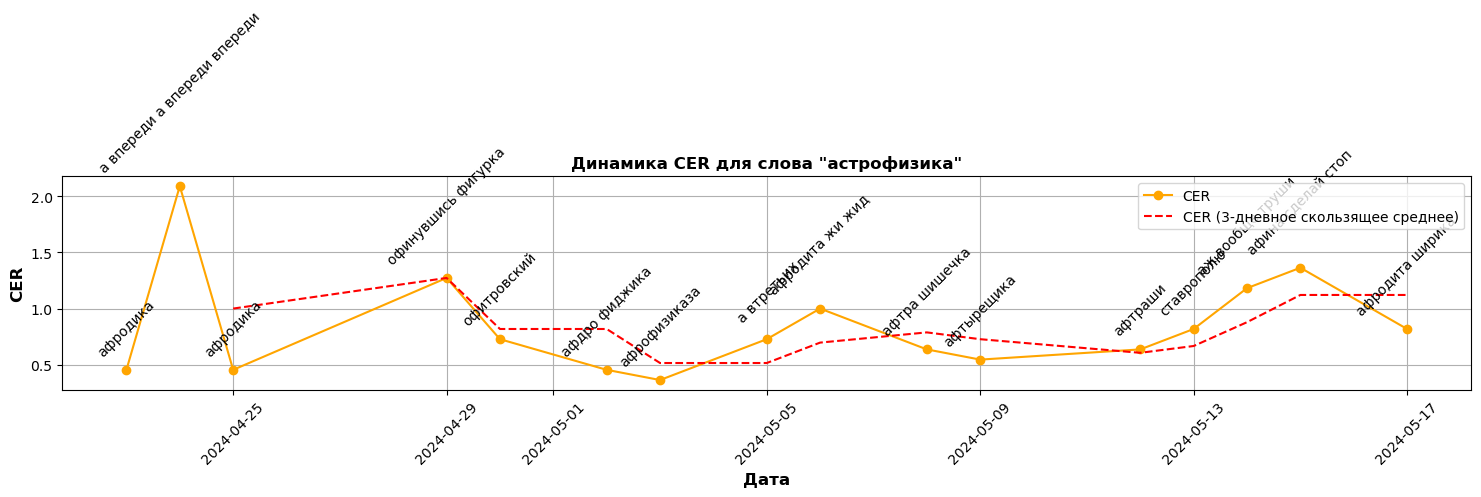

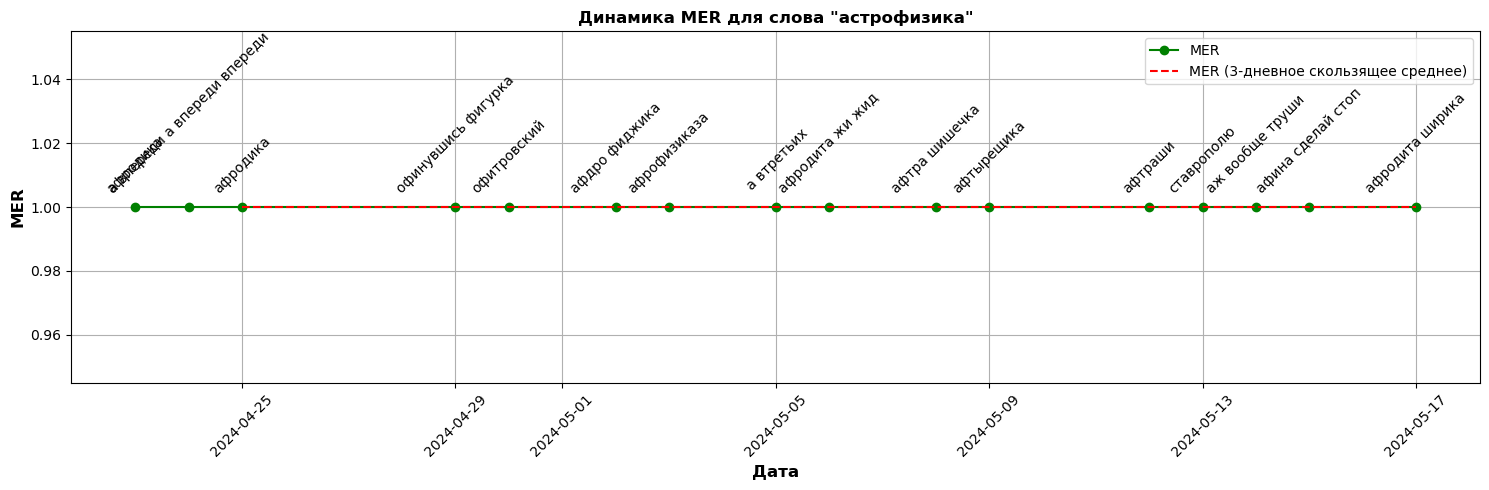

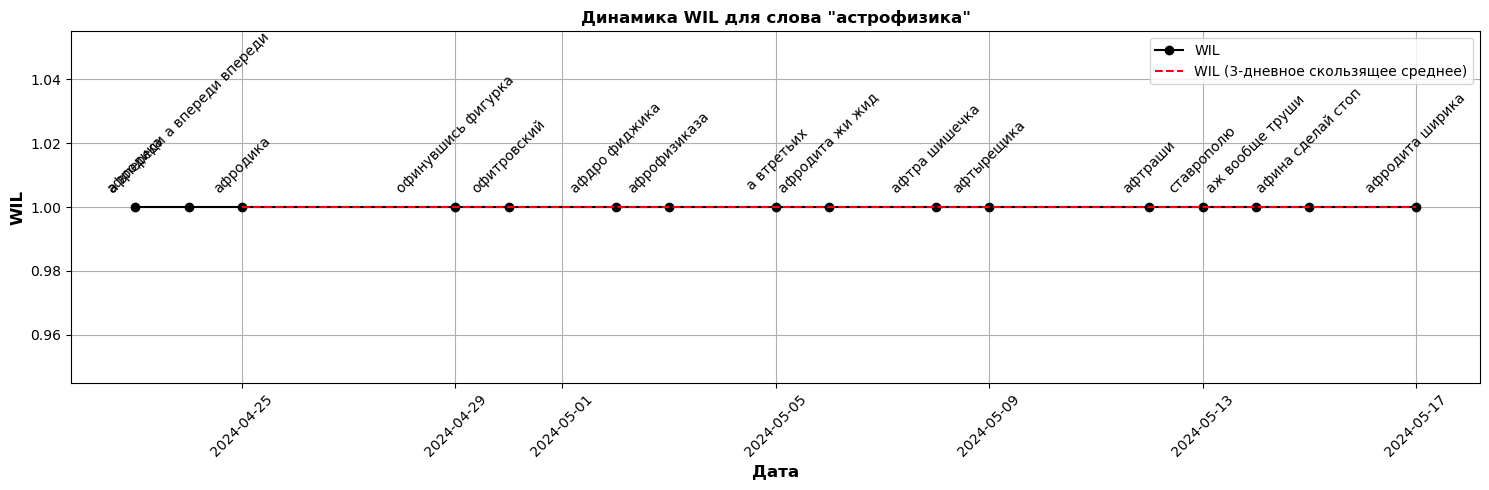

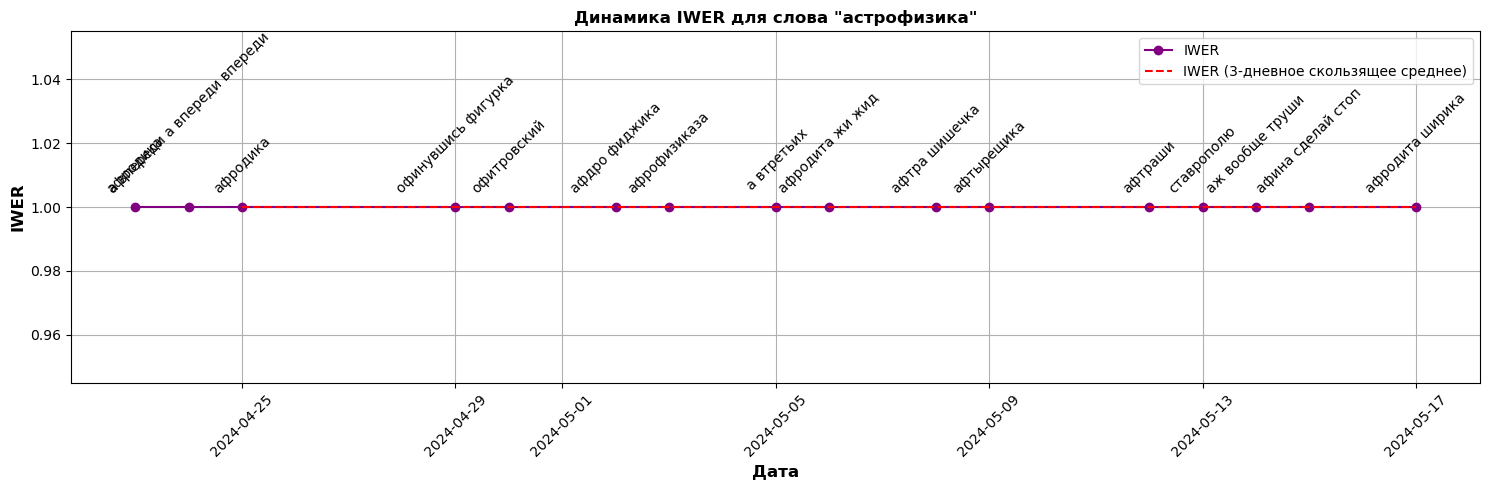

In [32]:
draw_plot('астрофизика')

#### Медицина - слово "Биология"

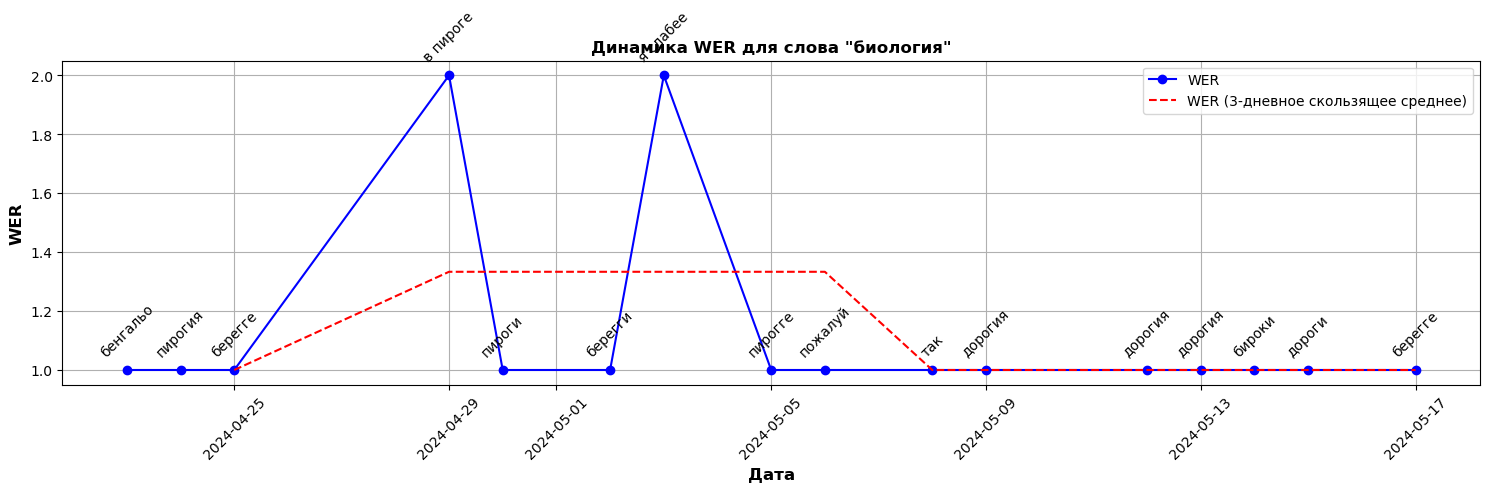

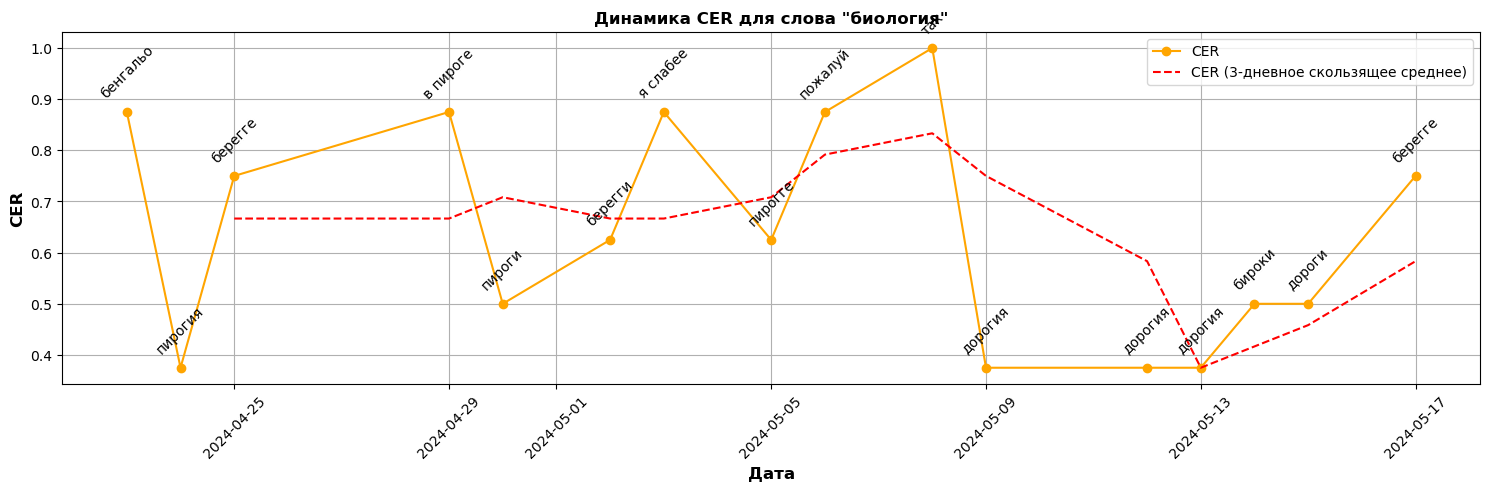

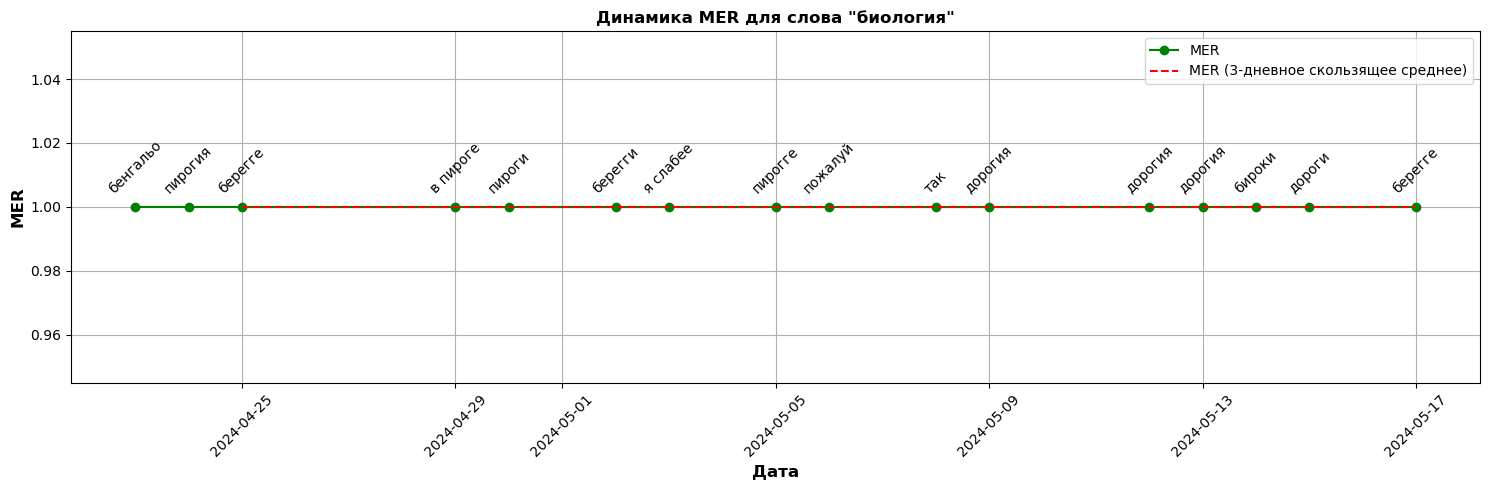

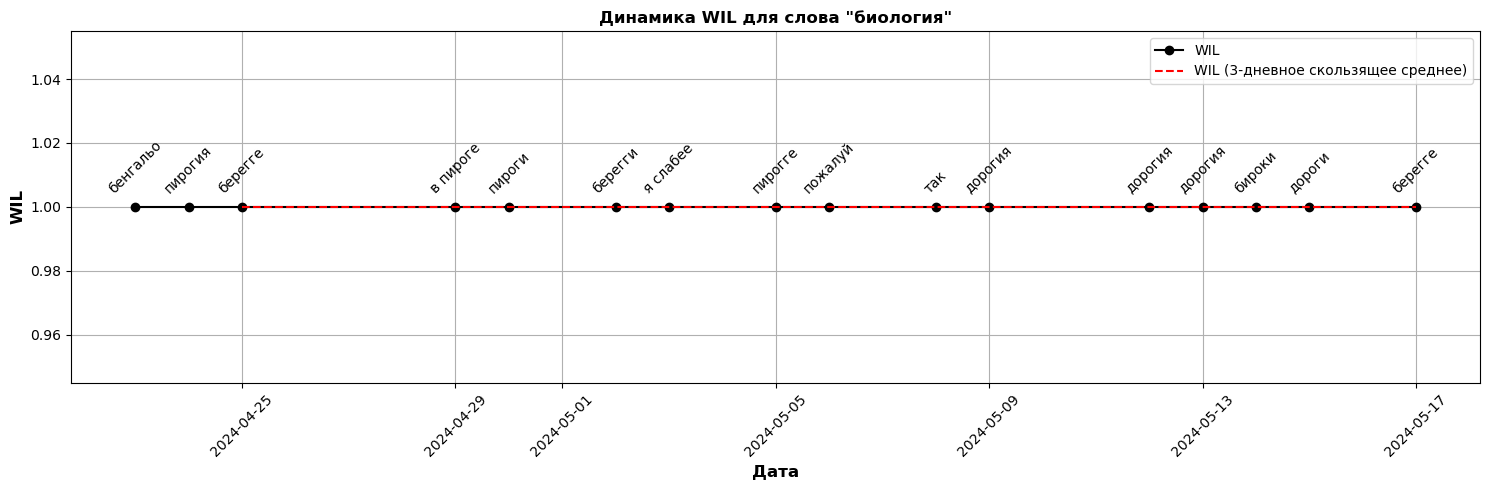

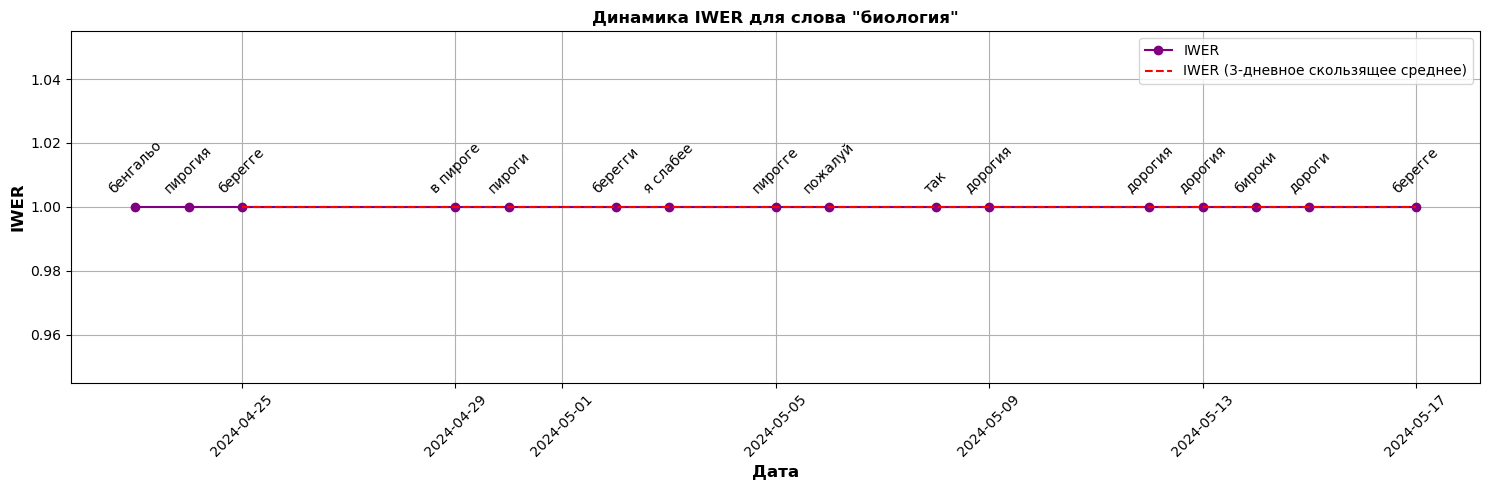

In [33]:
draw_plot('биология')

### Динамика средней значения всех слов по каждой теме

In [34]:
# Функция для вычисления изменений метрик
def compute_metrics_change(group):
    metrics = ['wer', 'cer', 'mer', 'wil', 'iwer']
    changes = {metric: (group[metric].iloc[-1] - group[metric].iloc[0]) for metric in metrics}
    
    return changes

In [35]:
for theme, words in collection.items():
    # Фильтрация данных по словам из текущей темы
    theme_df = research_df[research_df['word_for_check'].isin(words)]

In [31]:
# Датафрейм с изменениями метрик
changes_df = pd.DataFrame()

# Функция для построения графиков изменения метрик по темам
def draw_change_plot_by_theme(collection):
    change_records = []

    for theme, words in collection.items():
        # Фильтрация данных по словам из текущей темы
        theme_df = research_df[research_df['word_for_check'].isin(words)]

        if theme_df.empty:
            continue

        # Группировка по слову и вычисление изменений метрик
        grouped_df = theme_df.groupby('word_for_check')
        changes = {word: compute_metrics_change(group) for word, group in grouped_df}

        for metric in metrics:
            # Создание графика для текущей метрики
            plt.figure(figsize=(15, 5))
            words = list(changes.keys())
            values = [changes[word][metric] for word in words]

            # Отфильтруем слова с некорректными значениями
            words = [word for word, value in zip(words, values) if pd.notnull(value) and np.isfinite(value)]
            values = [value for value in values if pd.notnull(value) and np.isfinite(value)]

            # Определение направления изменения
            arrows = ['↓' if val < 0 else '↑' for val in values]
            labels = [f'{val:.2f} {arrow}' for val, arrow in zip(values, arrows)]
            colors = ['green' if val < 0 else 'red' for val in values]

            # Запись изменений в список для нового DataFrame
            for word, value in zip(words, values):
                change_records.append({'theme': theme, 'word': word, 'metric': metric, 'change': value})
            
            # Построение столбчатой диаграммы
            plt.bar(words, values, color=colors)

            # Добавление подписей
            for i, (word, label) in enumerate(zip(words, labels)):
                plt.text(i, values[i], label, ha='center', va='bottom' if values[i] < 0 else 'top')

            plt.title(f'Изменение {metric.upper()} по теме "{theme}"', fontweight='bold', fontsize=12)
            plt.xlabel('Слово', fontweight='bold', fontsize=12)
            plt.ylabel(f'Изменение {metric.upper()}', fontweight='bold', fontsize=12)
            plt.grid(True)
            plt.xticks(rotation=45)
            
            plt.tight_layout()
            plt.show()
            
    # Датафрейм с изменениями метрик
    changes_df = pd.DataFrame(change_records)

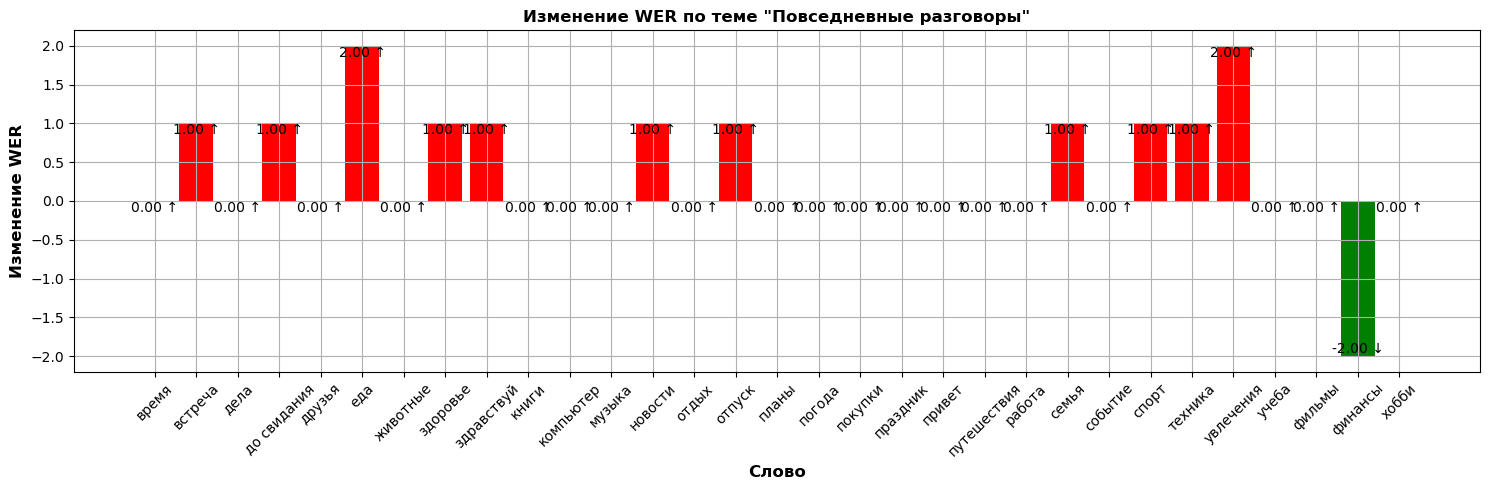

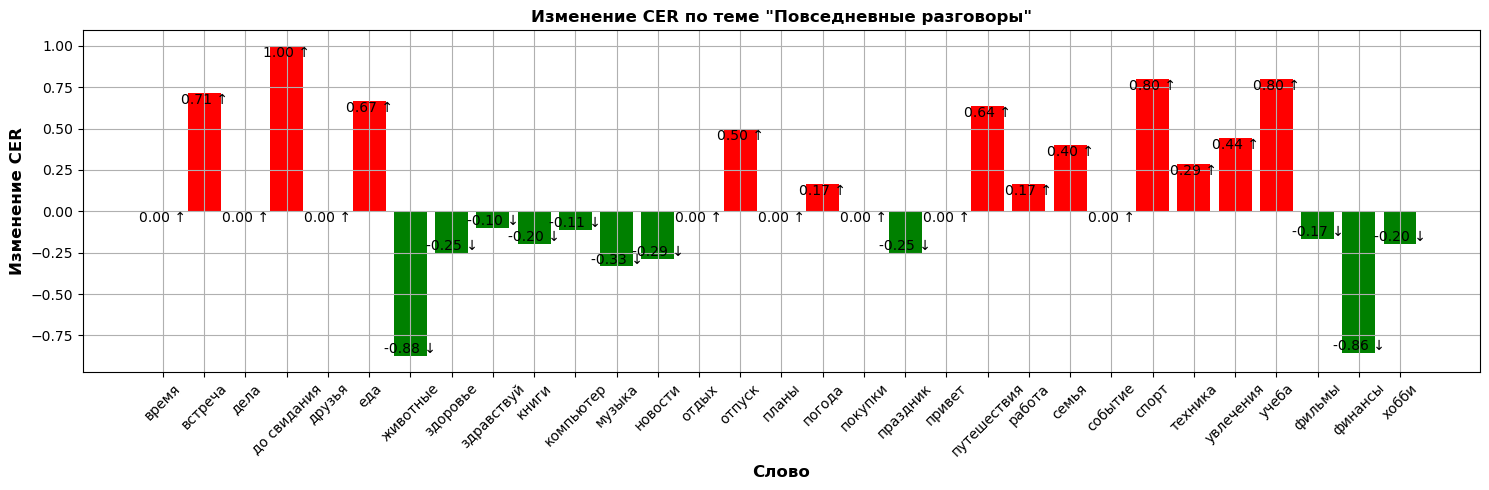

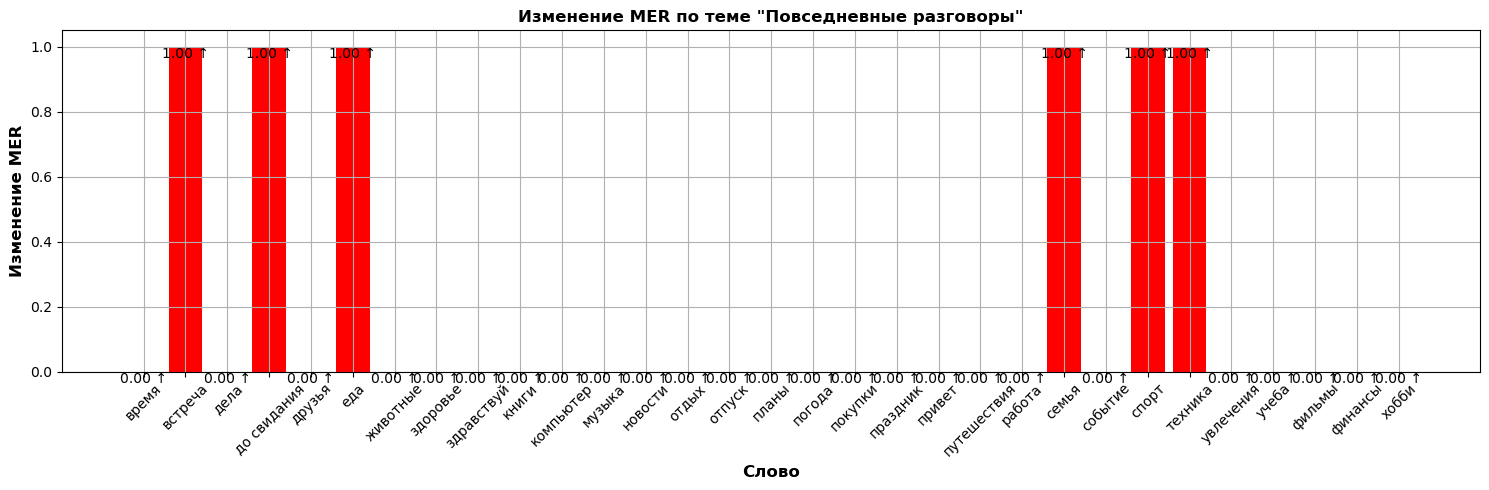

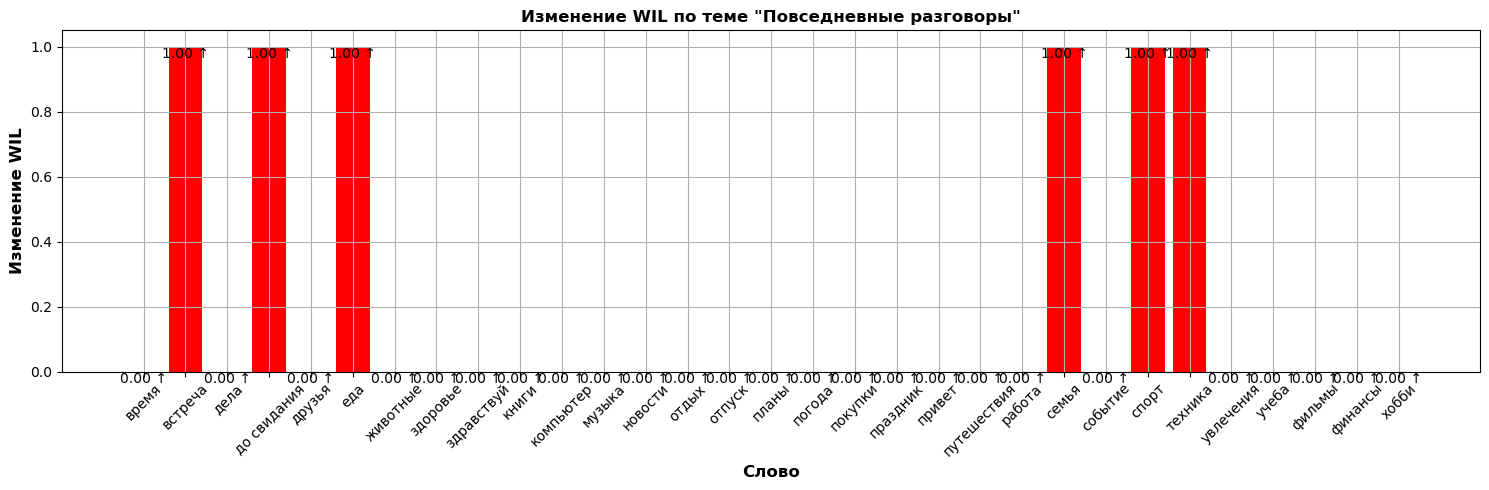

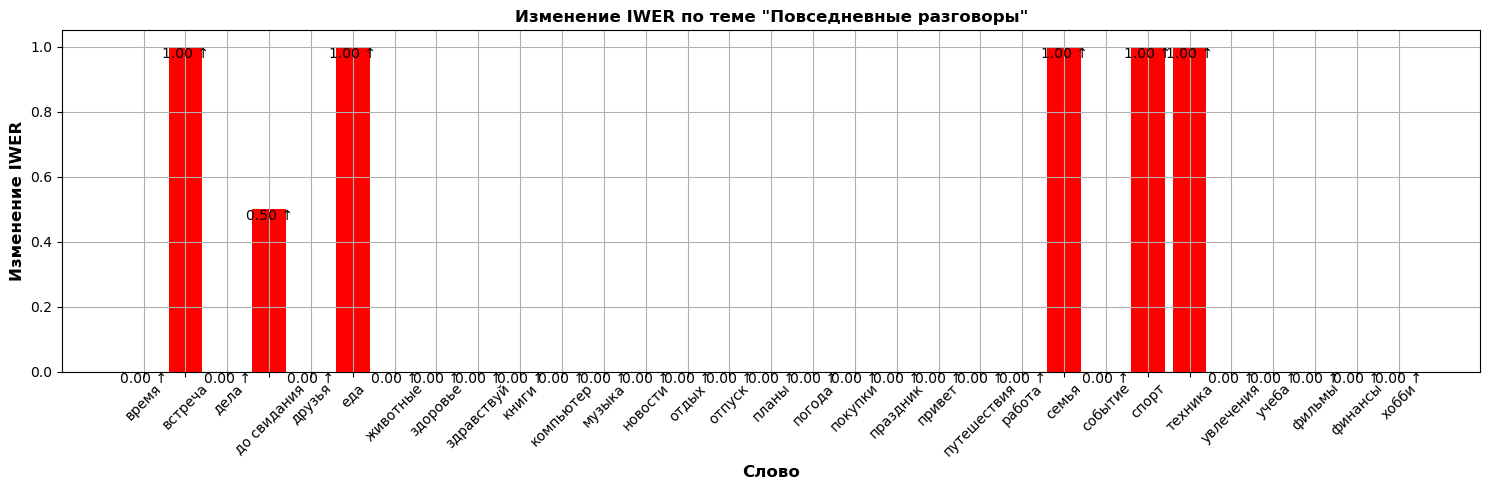

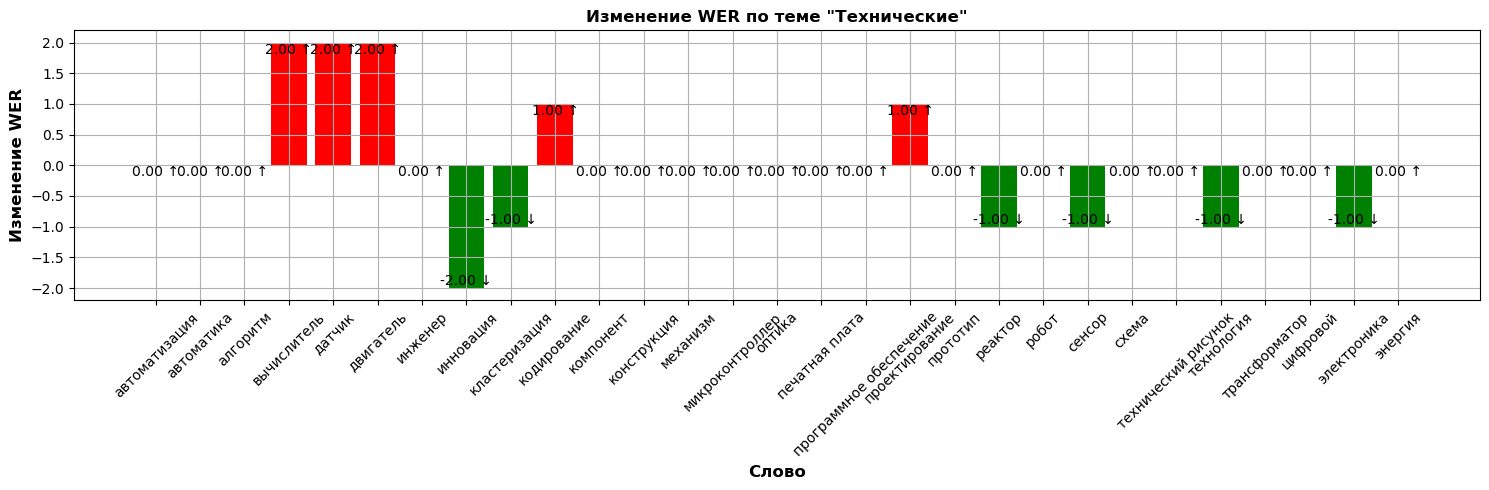

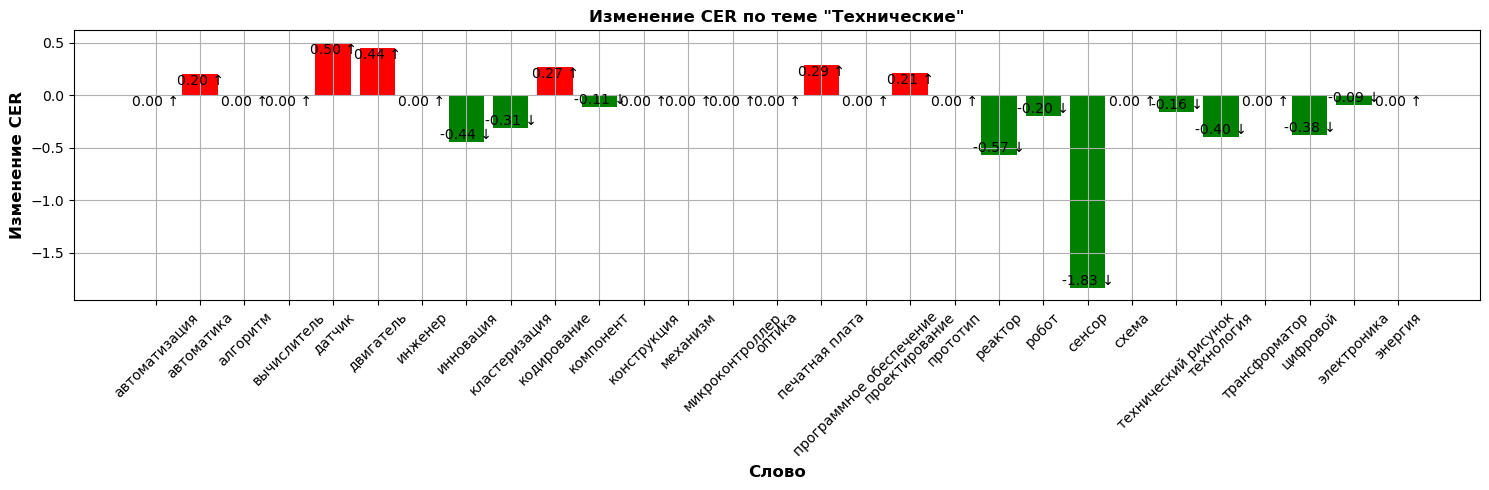

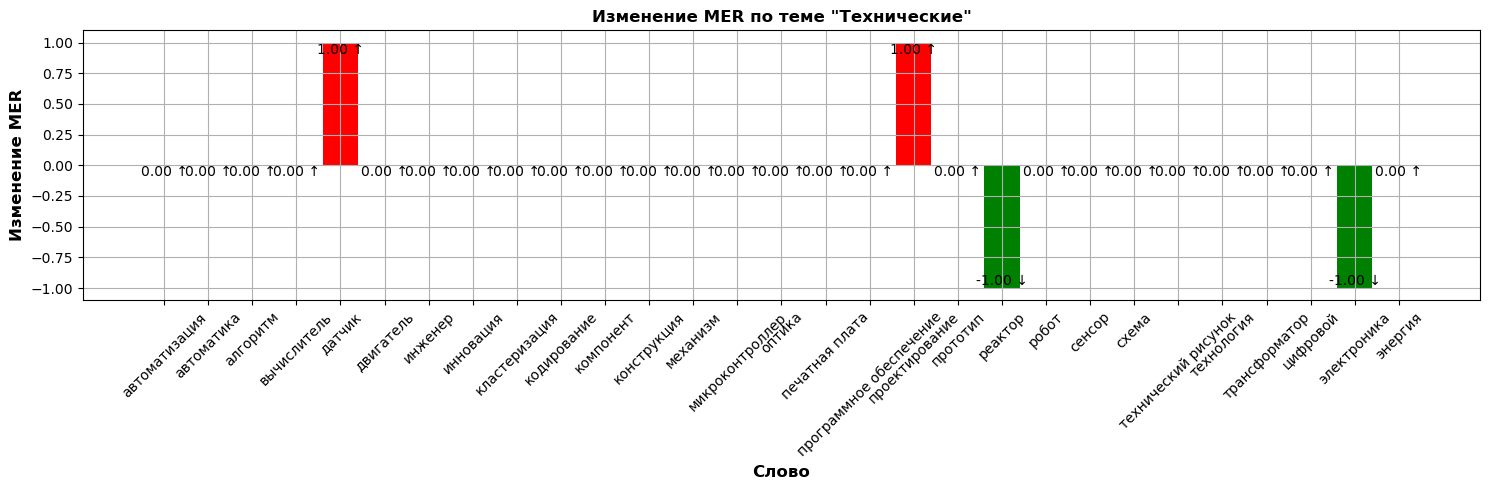

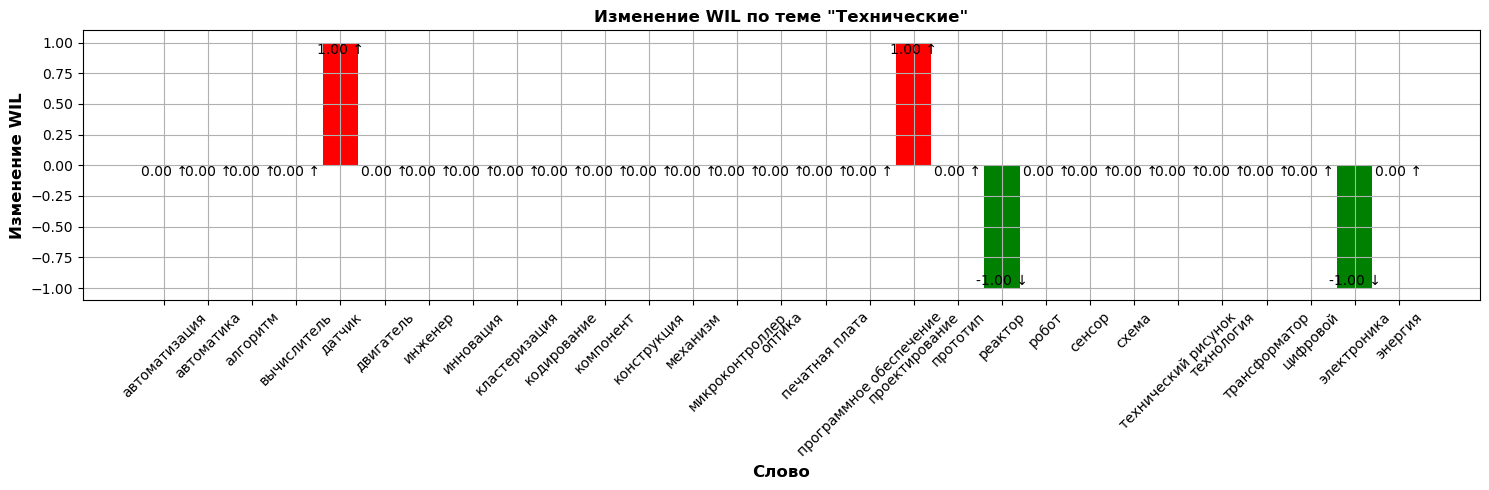

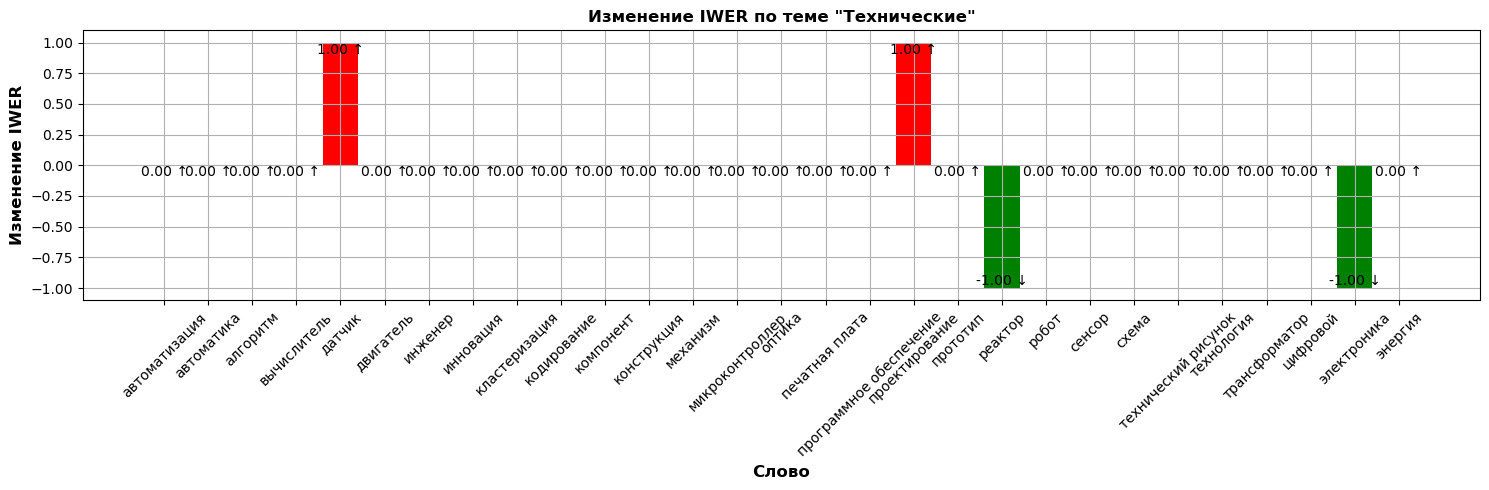

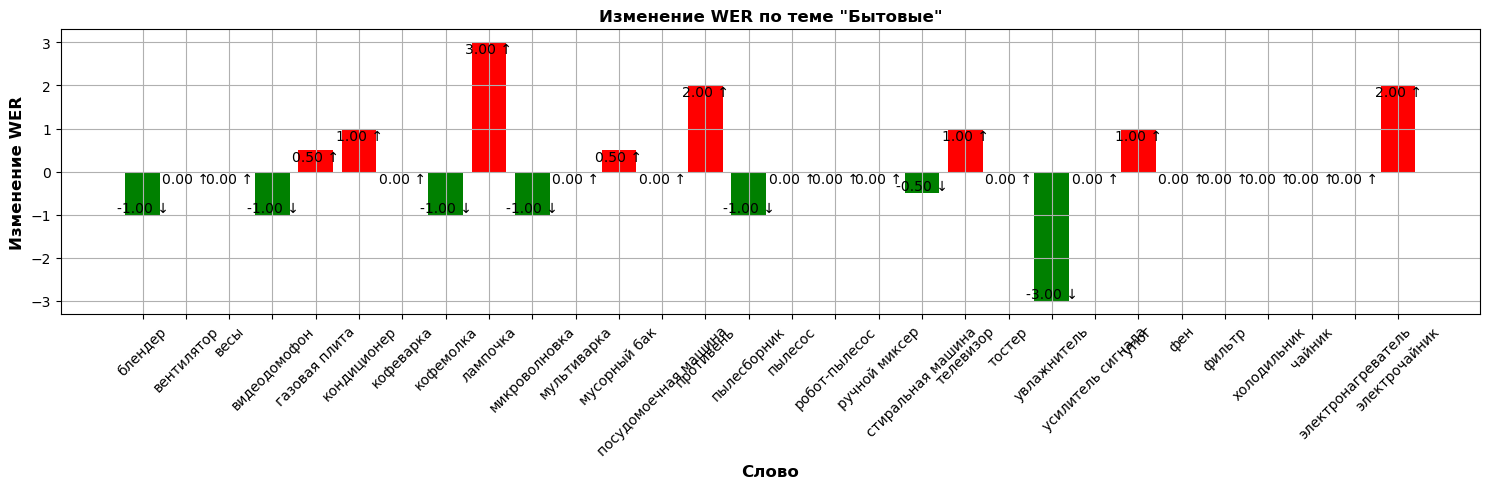

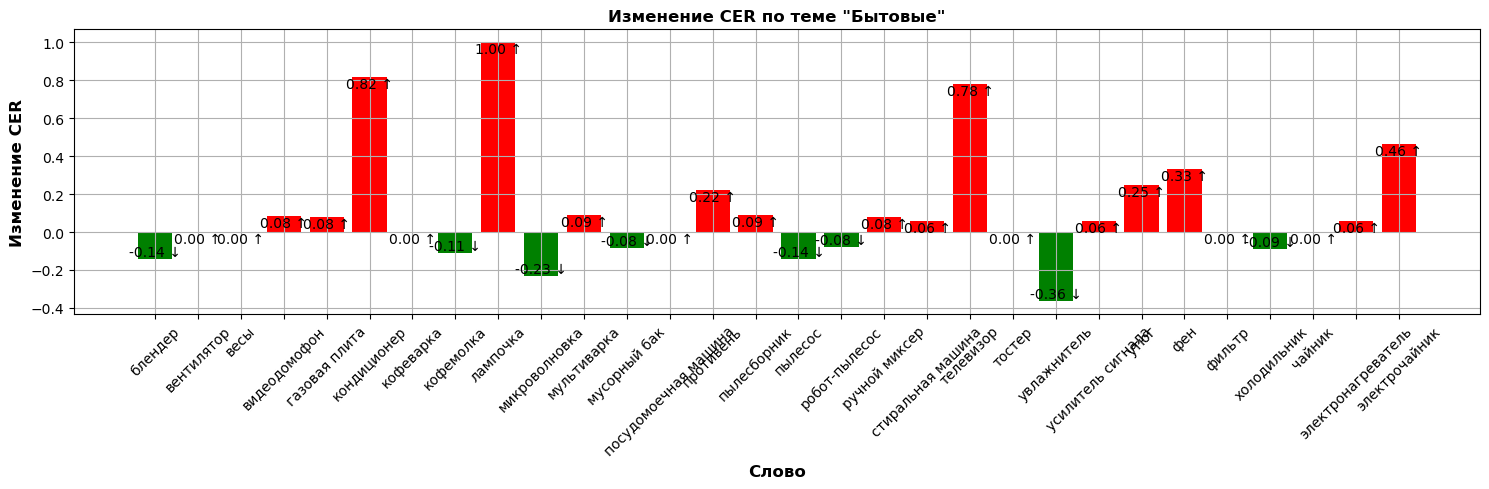

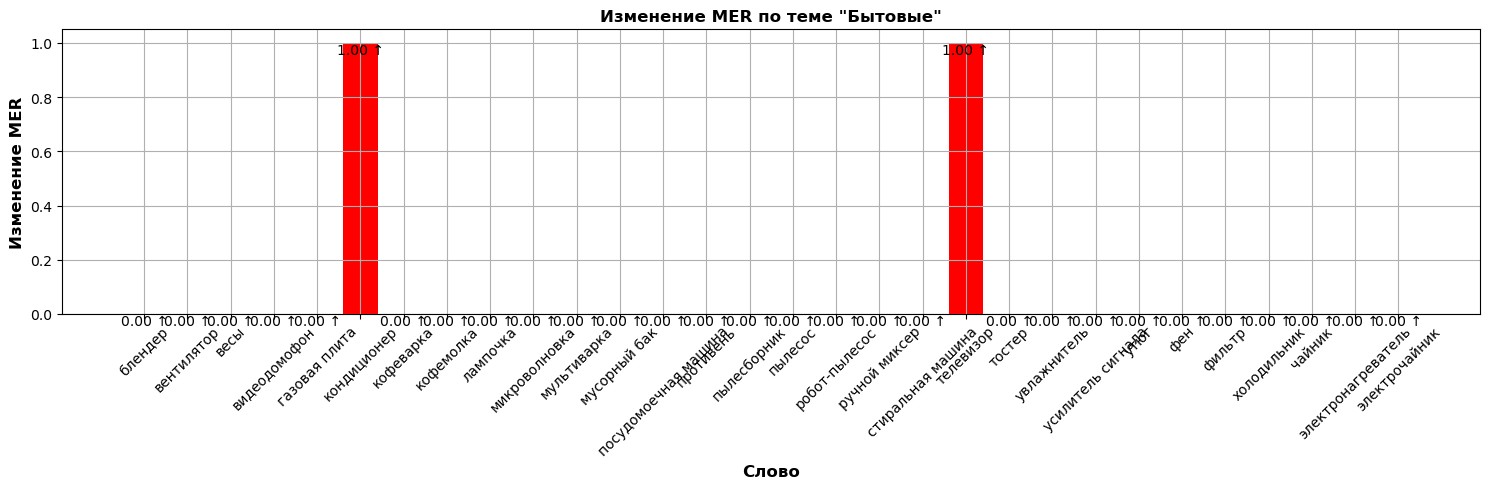

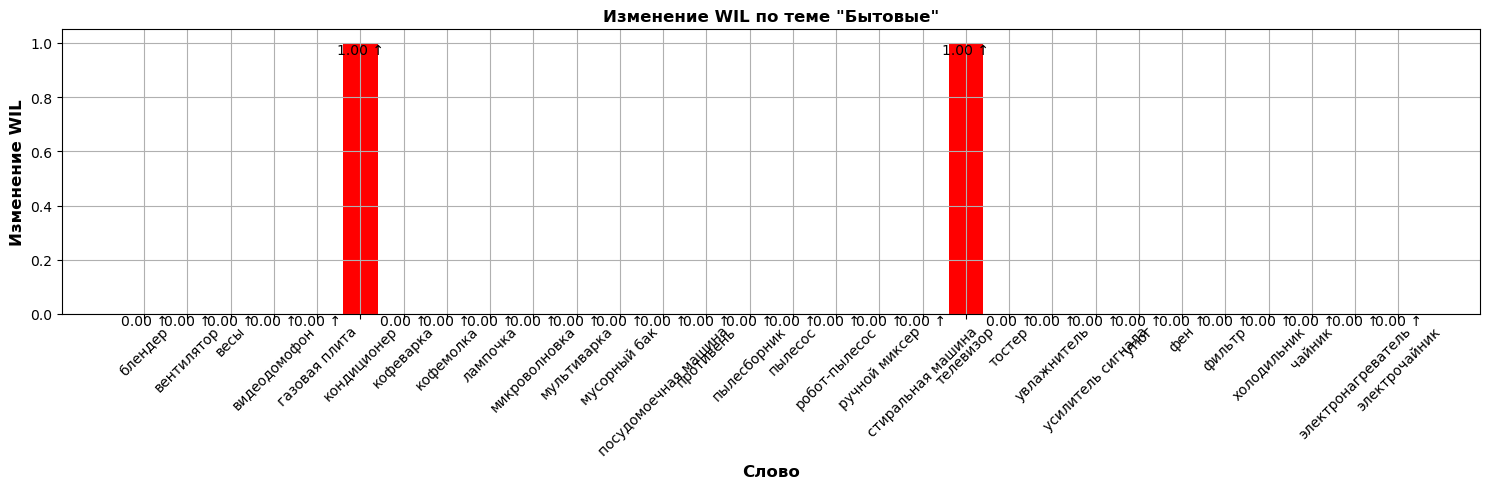

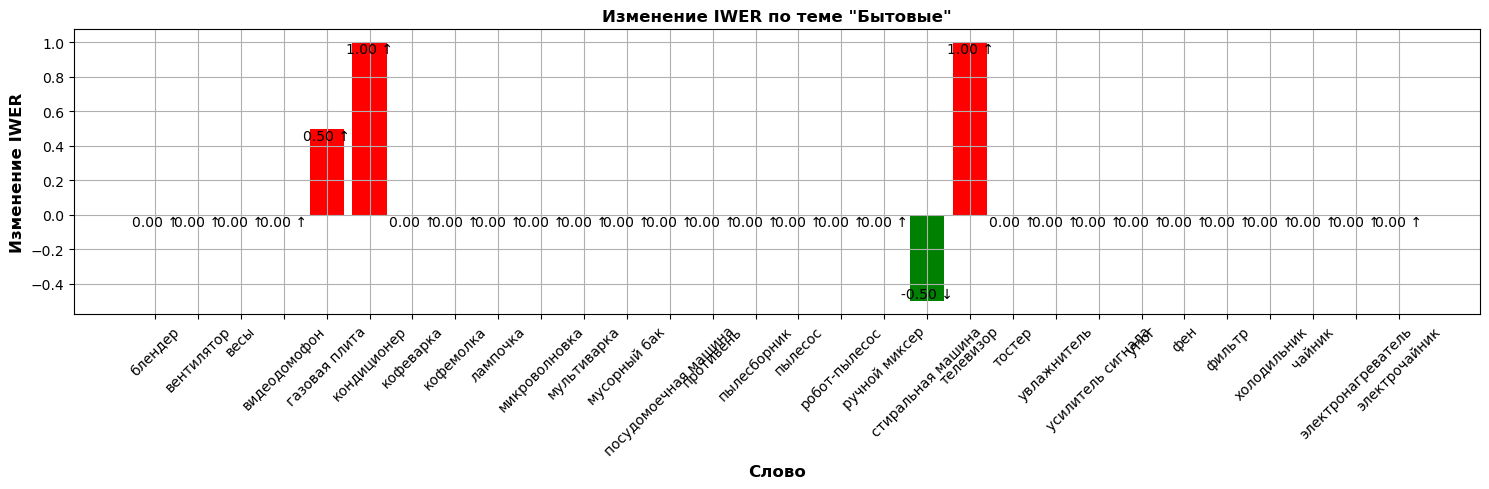

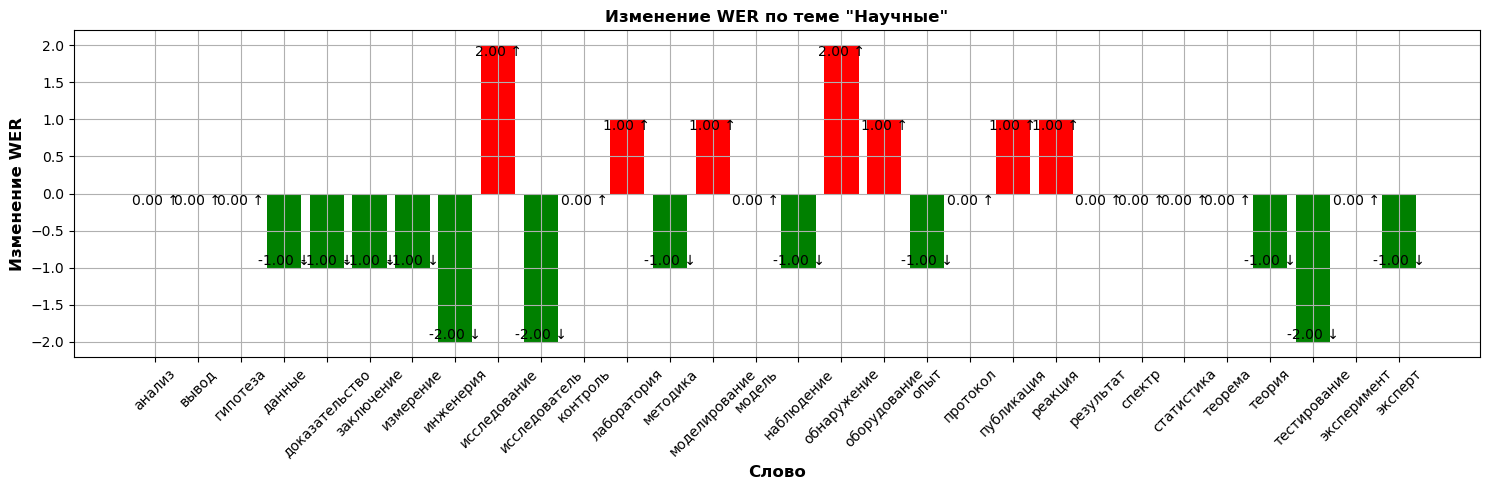

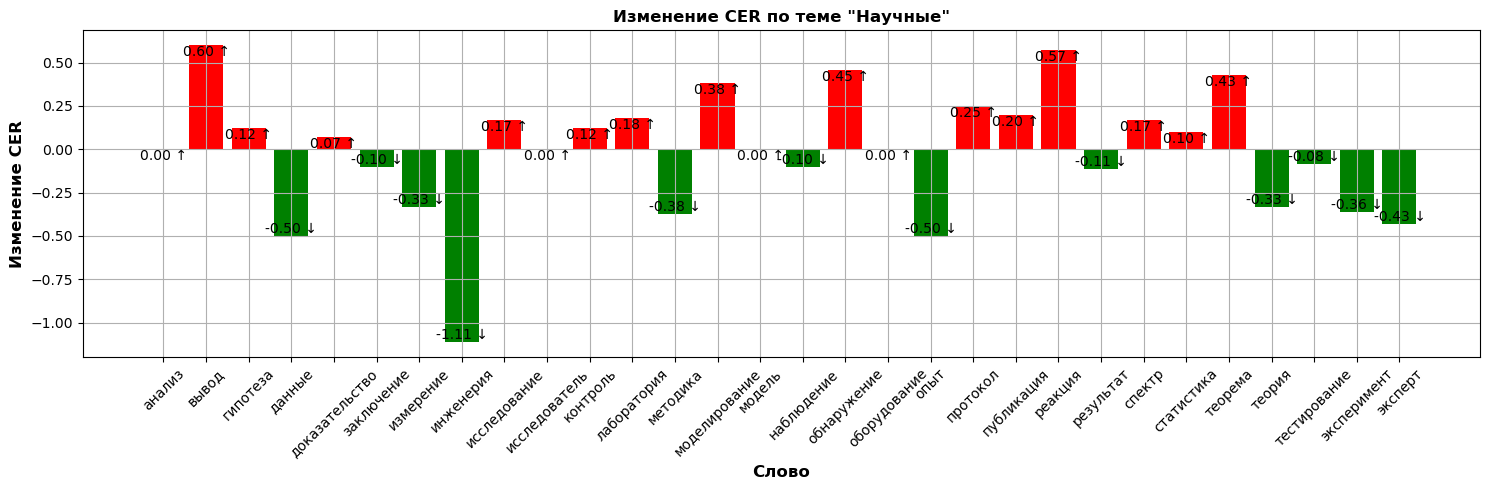

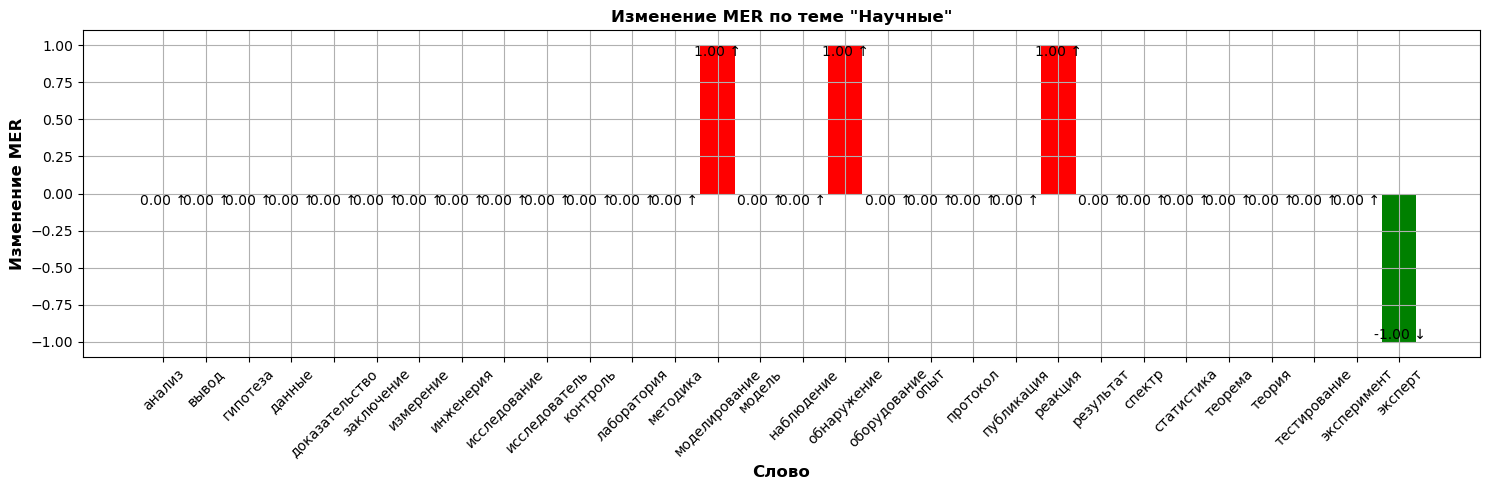

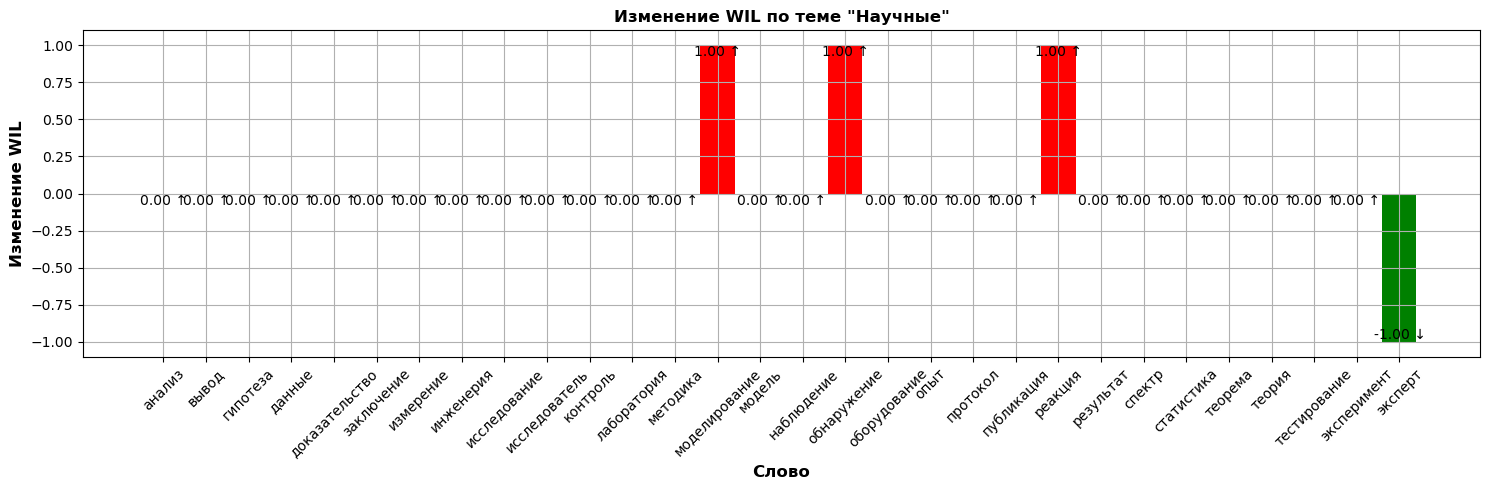

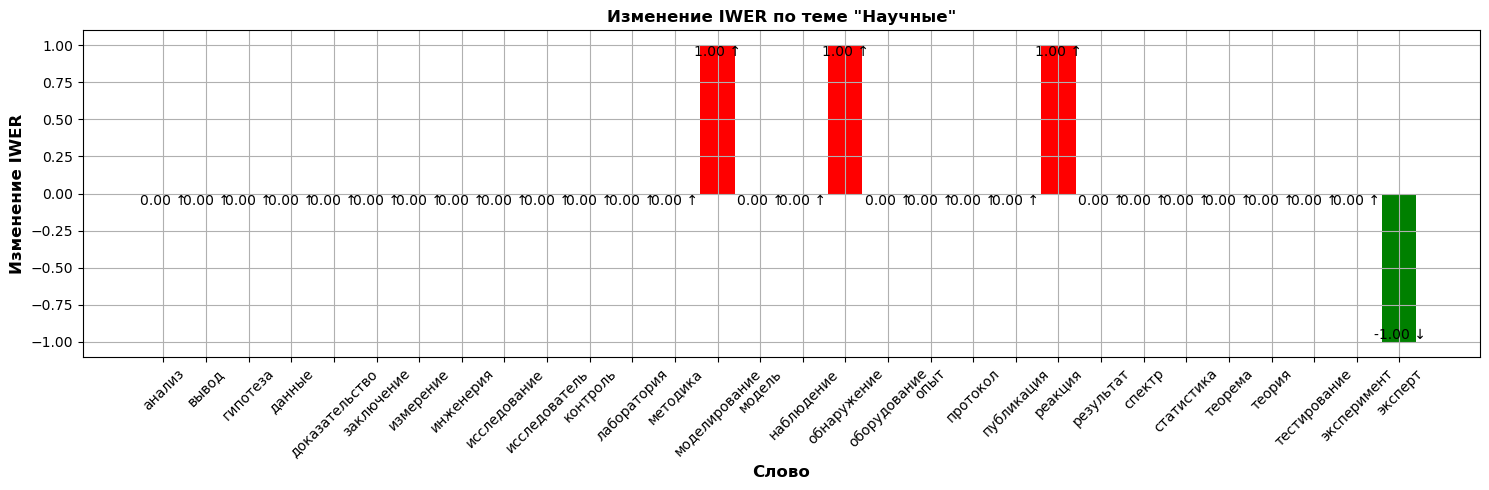

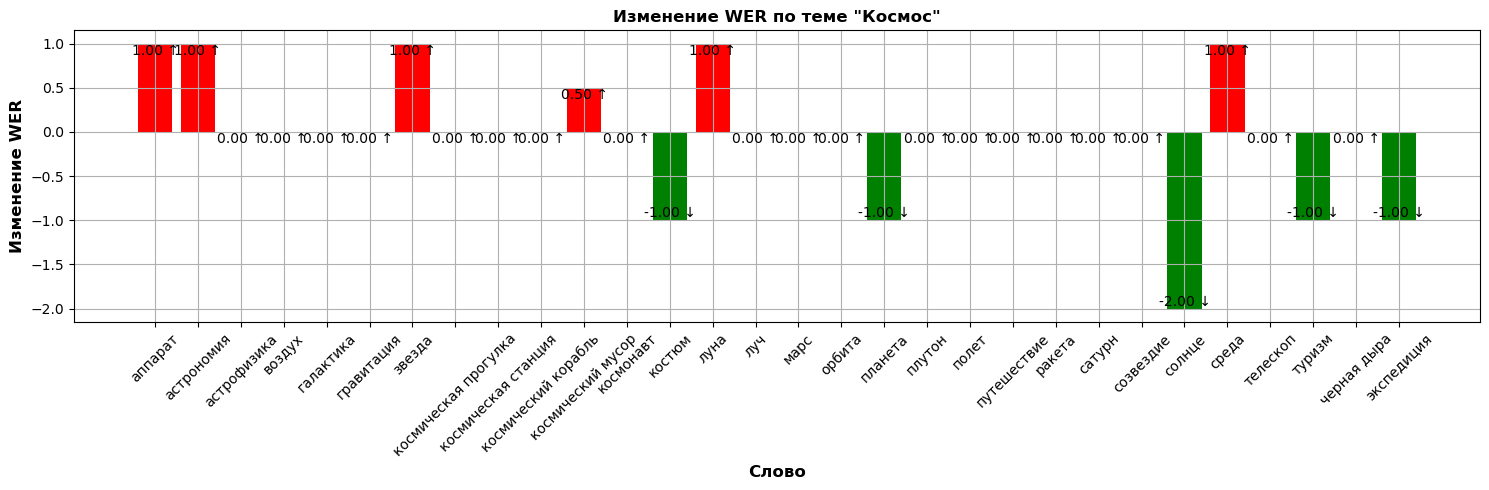

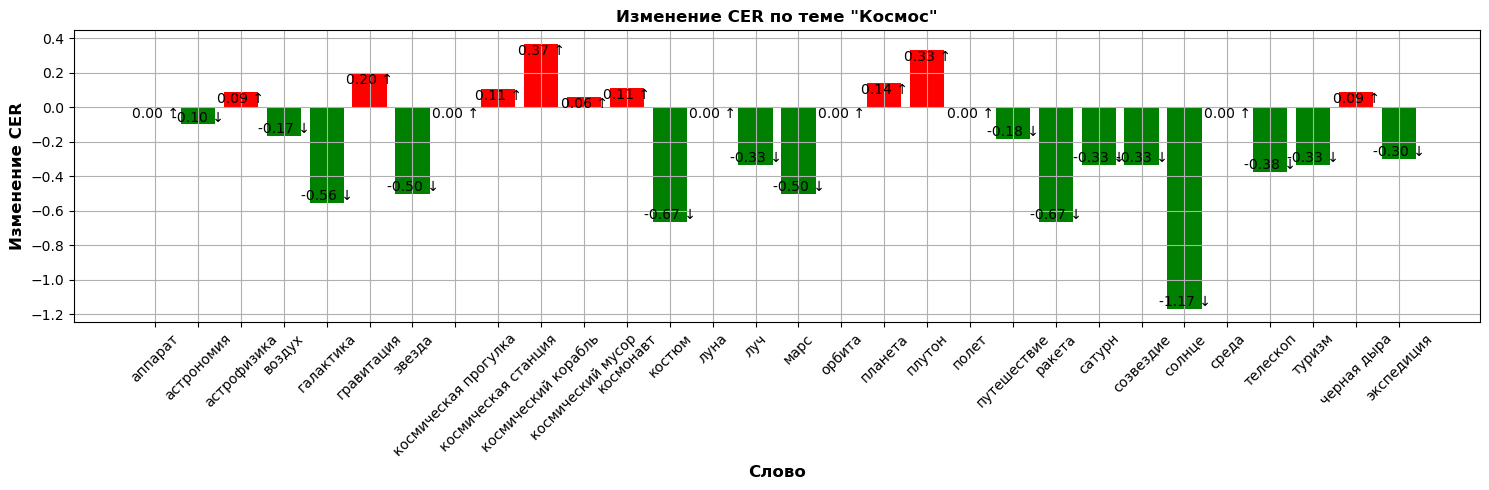

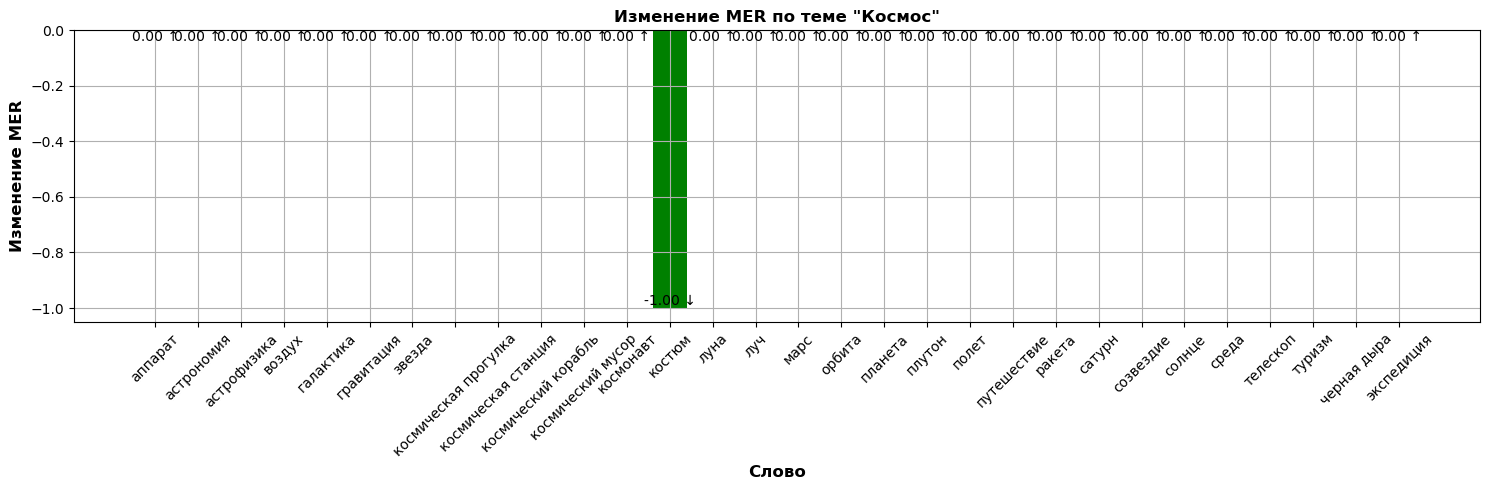

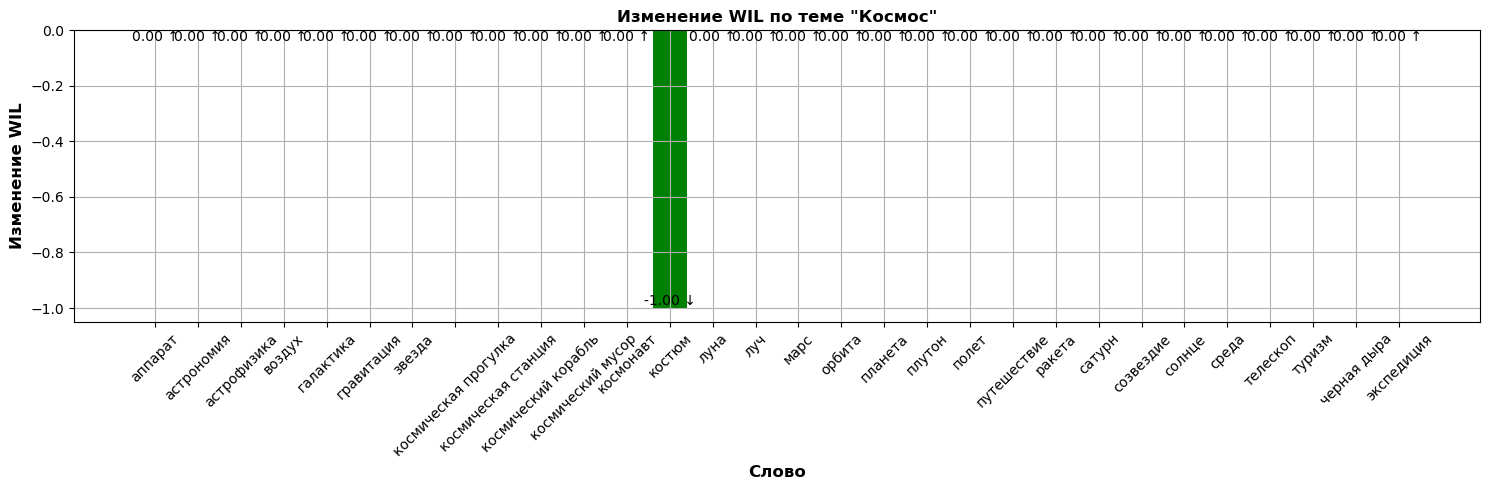

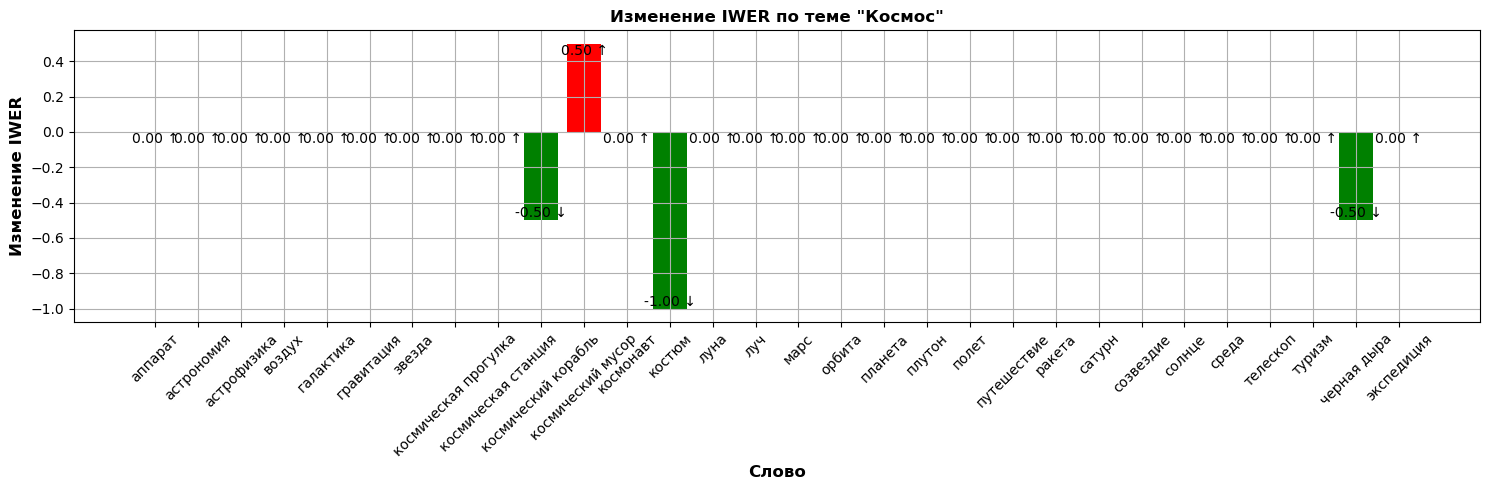

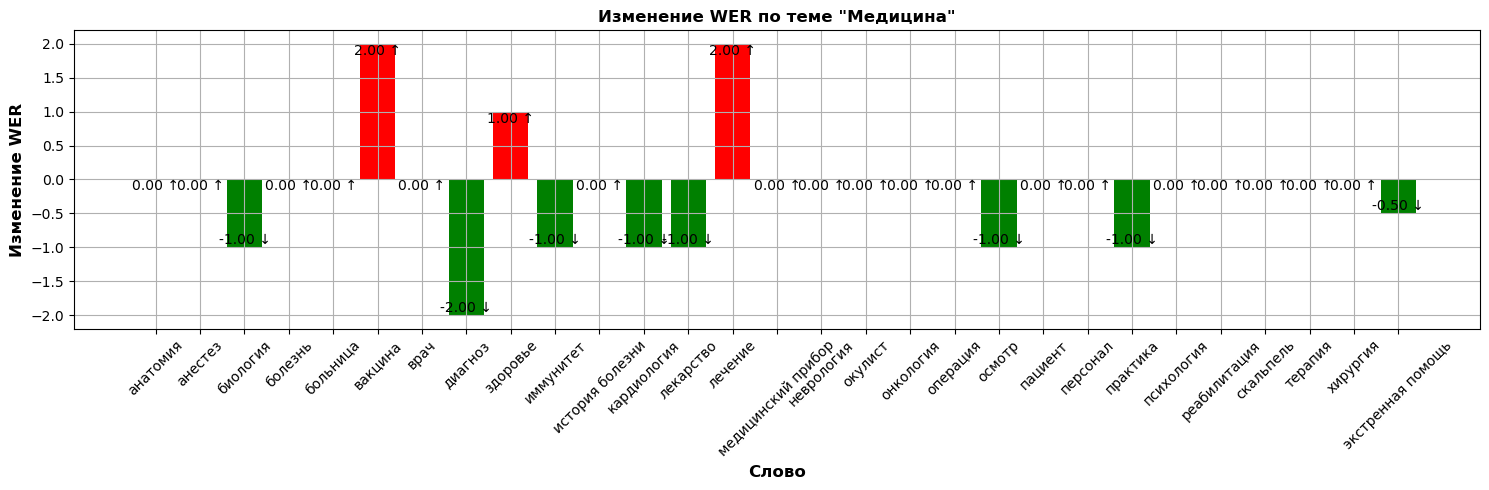

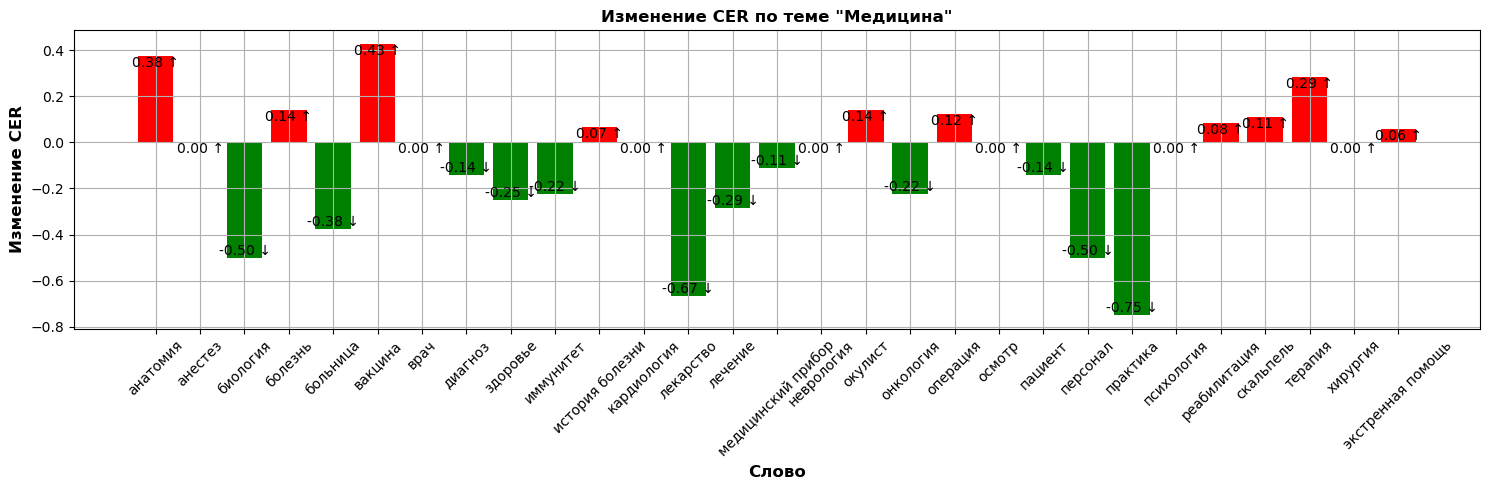

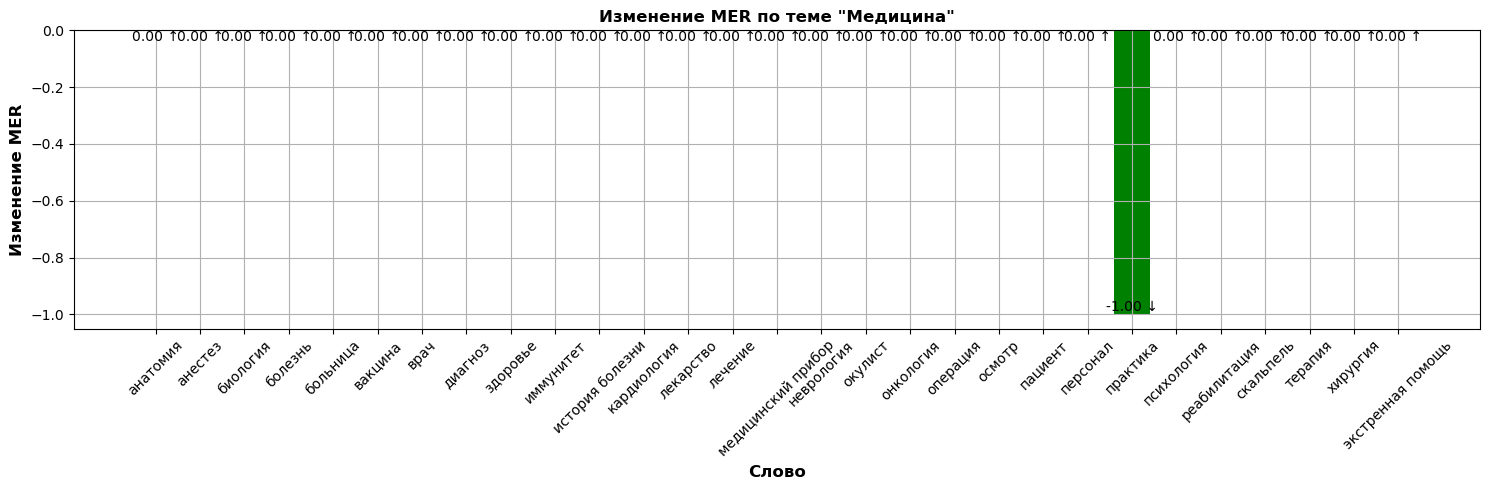

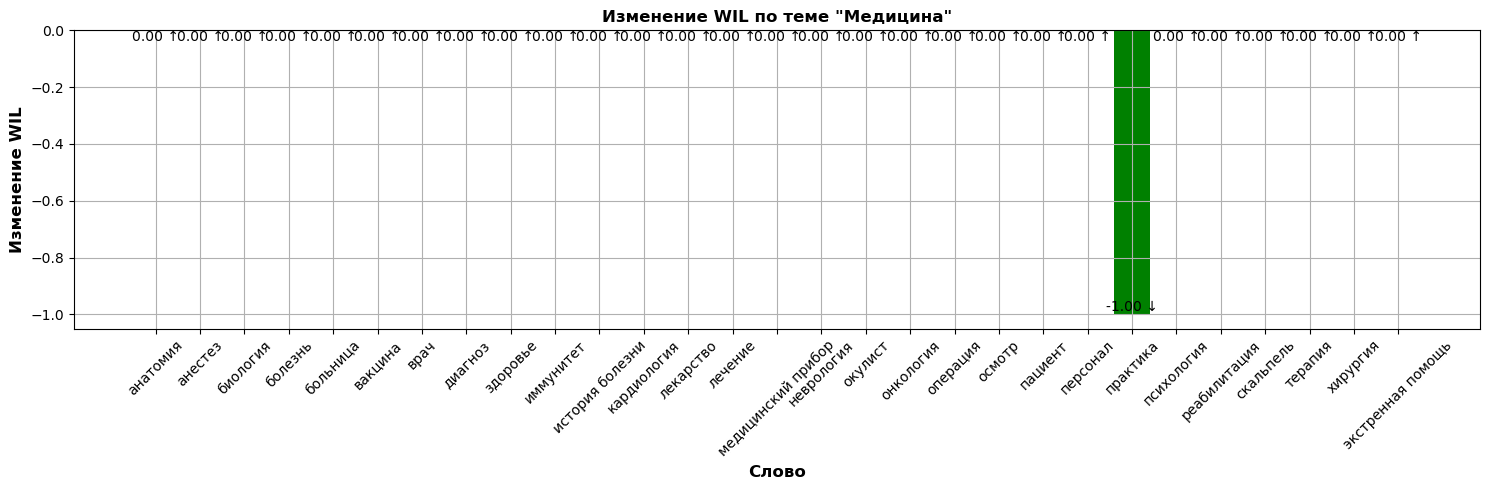

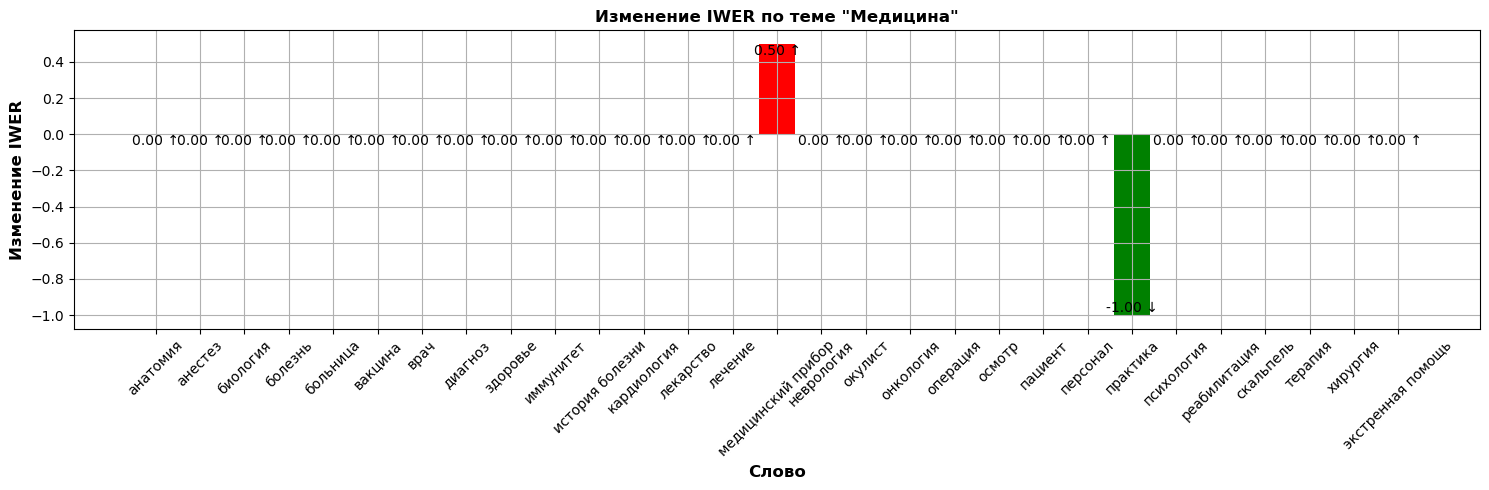

In [32]:
# Пример вызова функции
draw_change_plot_by_theme(collection)

### Корреляция тепловой карты матрицы

In [38]:
changes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 895 entries, 0 to 894
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   theme   895 non-null    object 
 1   word    895 non-null    object 
 2   metric  895 non-null    object 
 3   change  895 non-null    float64
dtypes: float64(1), object(3)
memory usage: 28.1+ KB


In [41]:
# Группировка данных по темам и метрикам
grouped_changes = changes_df.groupby(['theme', 'metric'])

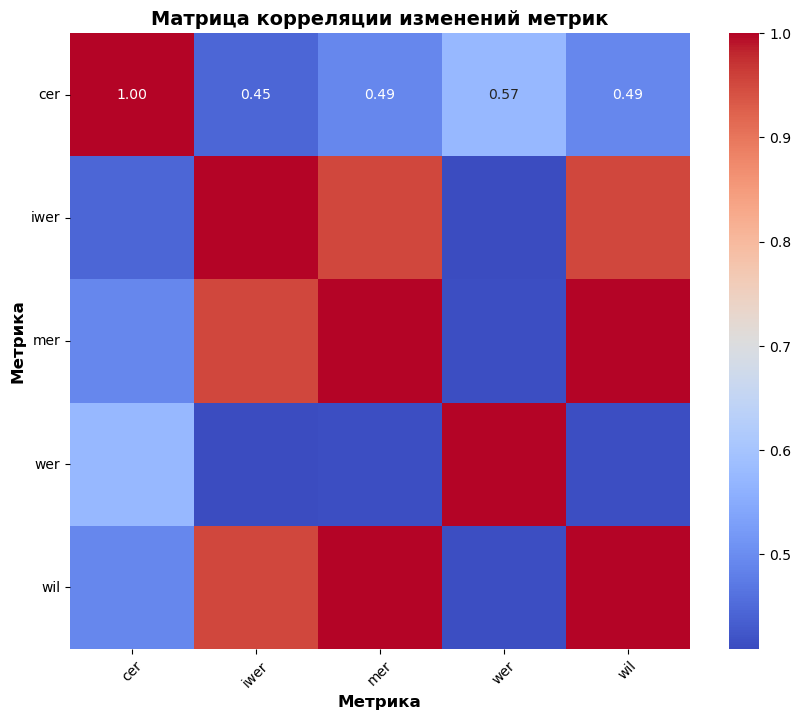

In [50]:
# Создание матрицы корреляции
correlation_matrix = changes_df.pivot_table(index='word', columns='metric', values='change', aggfunc='mean').corr()

# Построение тепловой карты корреляции
plt.figure(figsize=(10, 8))
sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Матрица корреляции изменений метрик', fontsize=14, fontweight='bold')
plt.xlabel('Метрика', fontsize=12, fontweight='bold')
plt.ylabel('Метрика', fontsize=12, fontweight='bold')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()